# Libraries 

In [1]:
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.load import dumps, loads
from langchain.retrievers.multi_query import MultiQueryRetriever

import os
import json
from typing import List
from langchain_core.documents import Document  # Adjust import path as necessary
import numpy as np 
from langchain.embeddings import CacheBackedEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_community.vectorstores import FAISS

import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langchain_community.document_transformers.openai_functions import create_metadata_tagger
from langchain_core.documents import Document as LangChainDocument
from langchain_openai import ChatOpenAI

import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dummy imports for demonstration; replace with your actual library imports
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')



import os
import json
from typing import List
from langchain_core.documents import Document  # Adjust import path as necessary
import numpy as np 



import os
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.load import dumps, loads
from langchain.retrievers.multi_query import MultiQueryRetriever

import pandas as pd

[nltk_data] Error loading punkt: <urlopen error [WinError 10054]
[nltk_data]     Connessione in corso interrotta forzatamente dall'host
[nltk_data]     remoto>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     Connessione in corso interrotta forzatamente dall'host
[nltk_data]     remoto>


In [34]:
import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langchain_community.document_transformers.openai_functions import create_metadata_tagger
from langchain_core.documents import Document as LangChainDocument
from langchain_openai import ChatOpenAI

import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dummy imports for demonstration; replace with your actual library imports
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')

class Processor:
    def __init__(self, zip_path, output_dir='output_json'):
        self.zip_path = zip_path
        self.output_dir = output_dir
        self.document_stopwords = [
            "COST OF PROCEDURE",
            "DURATION OF PROCEDURE",
            "FINAL RESOLUTION",
            "PRINCIPLES OF LAW USED FOR THE DECISION",
            "JUDGMENT",
            "LEGAL REASONS",
            "P.Q.M"
        ]
        self.original_metadata = []  # A list to store original metadata
        self.summary_metadata = []   # A list to store summary metadata
        self.nltk_stopwords = set(stopwords.words('english'))
        os.makedirs(self.output_dir, exist_ok=True)
        
        # # Define prompts for each specific section to summarize
        # prompt_legal_reasons = """Write a long as you  summary of the following text, take in account that this is legal text explaining the progress of a cause, try to summarize 
        # each step of it in a proper way (when you encounter omiss , it means that the name is anonymized  so don't care), latest ,(don't give me the name , but just identify the parties) 
        # talk in first person like you are part of it  in present time

        # ):
        # "{text}"
        # SUMMARY:"""
        
        #2nd template 
        # Define prompts for each specific section to summarize
        prompt_legal_reasons = """Write a short as you  summary of the following text, take in account that this is legal text explaining the progress of a cause, try to summarize 
        each step of it in a proper way (when you encounter omiss , it means that the name is anonymized  so don't care), i repeat,(don't give me the name , but just identify the parties) 
        talk as u are explaining it to a not legal person , do not make an introduction , directly summarize it in a clear way

        ):
        "{text}"
        SUMMARY:"""

        llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
        self.llm_chain_legal_reasons = LLMChain(llm=llm, prompt=PromptTemplate.from_template(prompt_legal_reasons))
        


        # Define the schema for metadata tagging
        schema = {
            "properties": {
                "cost": {"type": "string", "description": "Cost associated with the legal procedure. give me back just the value followed by €" },
                "duration": {"type": "string", "description": "Duration of the legal procedure. give me back just the duration using years or months "},
                "civil_codes_used": {"type": "array", "items": {"type": "string"}, "description": "List of civil codes referenced in the document return in this format art. (number of article), "},
                "law_type": {"type": "string", "enum": ["Succession", "Divorce"], "description": "Type of law the document pertains to (Succession or Divorce only) "},
                "succession_type": {"type": "string","enum": ["testamentary", "legal"], "description": "differentiates between testamentary succession (with a will) and legal succession (without a will)"},
                "subject_of_succession": {"type": "string", "description": "Filters by type of inheritance assets involved (real estate, bank accounts, company shares, etc.) be very concise"},
                "testamentary_clauses": {"type": "array", "items": {"type": "string"}, "description": "Specific testamentary clauses mentioned for example, legacies, trusts, or clauses excluding from inheritance (e.g. 			         disinheritance,clause) "},
                "disputed_issues": {"type": "array", "items": {"type": "string"},"enum": ["validity of will", "division of assets" , "legitimacy"], "description": "This section identifies specific disputes, such as the validity of a will, 	         the division of assets, or questions of legitimacy"},
                "relationship_between_parties": {"type": "string", "description": "Relationship between heir and de cuius "},
                "number_of_persons_involved": {"type": "integer", "description": "Number of heirs and/or legatees."},
                "nature_of_separation": {"type": "string", "enum": ["Voluntary", "Judicial","consensual" , "contentious"], "description": "Nature of separation, e.g., voluntary, judicial"},
                "presence_of_children": {"type": "boolean", "description": "Indicates if children are involved whether issues with the maintainance, custody ,visitation rights."},
                "marital_regime": {"type": "string","enum": ["community of property", "separation of property","issues relatively division of common properties" ], "description": "Marital regime affecting the separation/divorce and issues 	         relatively common properties."},
                "financial_support": {"type": "string", "description": "Details about alimony or spousal maintenance give me back just the value followed by €"},
                "duration_of_marriage": {"type": "string", "description": "Duration of the marriage being dissolved.give me back just the duration using years or months"},
            },
            "required": ["keyword", "text"]
        }
        # Define the schema for metadata tagging
        schema_2 = {
            "properties": {
            "law": {"type": "string", "enum": ["Inheritance", "Divorce"], "description": "Type of law the query pertains to (Succession or Divorce only) "},
            "state": {"type": "string", "enum": ["ITALY", "BELGIUM","ESTONIA","CROATIA","LITHUANIA","SLOVENIA"], "description": "Country specified by the query through the user"},
            "succession_type": {"type": "string","enum": ["testamentary", "legal"], "description": "differentiates between testamentary succession (with a will) and legal succession (without a will)"},
            "subject_of_succession": {"type": "string", "description": "Filters by type of inheritance assets involved (real estate, bank accounts, company shares, etc.) be very concise"},
            "testamentary_clauses": {"type": "array", "items": {"type": "string"}, "description": "Specific testamentary clauses mentioned for example, legacies, trusts, or clauses excluding from inheritance (e.g. 			         disinheritance,clause) "},
            "disputed_issues": {"type": "array", "items": {"type": "string"},"enum": ["validity of will", "division of assets" , "legitimacy"], "description": "This section identifies specific disputes, such as the validity of a will, 	         the division of assets, or questions of legitimacy"},
            "relationship_between_parties": {"type": "string", "description": "Relationship between heir and de cuius "},
            "number_of_persons_involved": {"type": "integer", "description": "Number of heirs and/or legatees."},
            "nature_of_separation": {"type": "string", "enum": ["Voluntary", "Judicial","consensual" , "contentious"], "description": "Nature of separation, e.g., voluntary, judicial"},
            "presence_of_children": {"type": "boolean", "description": "Indicates if children are involved whether issues with the maintainance, custody ,visitation rights."},
            "marital_regime": {"type": "string","enum": ["community of property", "separation of property","issues relatively division of common properties" ], "description": "Marital regime affecting the separation/divorce and issues 	         relatively common properties."},
            },
            "required": ["keyword", "text"]
        }

        self.document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm)
        self.query_transformer = create_metadata_tagger(metadata_schema=schema_2, llm=llm)
        self.original_documents = []  # To store original document texts   ADDED
        self.document_metadata = []  # To store metadata for each document   ADDED
        
    def extract_zip(self):
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            zip_ref.extractall("extracted_docs")

    def process_documents(self):
        self.extract_zip()
        files = glob.glob('extracted_docs/**/*.docx', recursive=True)
        for file in files:
            self.process_file(file)
        
        # Convert lists to DataFrames
        original_metadata_df = pd.DataFrame(self.original_metadata)
        summary_metadata_df = pd.DataFrame(self.summary_metadata)
        
        return original_metadata_df, summary_metadata_df

    def process_file(self, file_path):
        doc = Document(file_path)
        full_text = [para.text for para in doc.paragraphs if para.text.strip() != '']
        if not full_text:
            return None, None  # Return None if document is empty

        text = "\n".join(full_text)
        self.original_documents.append({"file_path": file_path, "text": text})  # Store original text
        
        # Initial tagger application on the whole document
        original_document = LangChainDocument(page_content=text)
        enhanced_document = self.document_transformer.transform_documents([original_document])[0]
        self.original_metadata.append({"file_path": file_path, "metadata": enhanced_document.metadata})
        
        # Summarize and process structured chunks
        structured_chunks = self.split_and_structure_text(text)
        summaries = self.summarize_document(structured_chunks)
        summary_document = LangChainDocument(page_content=summaries)
        summary_metadata = self.document_transformer.transform_documents([summary_document])[0].metadata
        self.summary_metadata.append({"file_path": file_path, "metadata": summary_metadata})
        
        # Return both sets of metadata
        return enhanced_document.metadata, summary_metadata
        
        
        


    def split_and_structure_text(self, text):
        structured_chunks = []
        current_pos = 0
        prev_stopword = "CASE_ID"
        for stopword in self.document_stopwords:
            stopword_pos = text.find(stopword, current_pos)
            if stopword_pos != -1:
                chunk = text[current_pos:stopword_pos].strip()
                if chunk:
                    structured_chunks.append({"keyword": prev_stopword, "text": self.clean_data(chunk)})
                current_pos = stopword_pos + len(stopword)
                prev_stopword = stopword
        final_chunk = text[current_pos:].strip()
        if final_chunk:
            structured_chunks.append({"keyword": prev_stopword, "text": self.clean_data(final_chunk)})
        return structured_chunks

    def clean_data(self, text_chunk):
        tokens = word_tokenize(text_chunk)
        filtered_tokens = [token for token in tokens if token.lower() not in self.nltk_stopwords]
        cleaned_text = " ".join(filtered_tokens)
        return cleaned_text

    def summarize_document(self, structured_chunks):
        # Initialize a list to hold summaries of each chunk.
        chunk_summaries = []

        # Iterate over each chunk and summarize it.
        for chunk in structured_chunks:
            text_for_summarization = chunk["text"]
            # Assume `self.llm_chain_general.run()` is a method to summarize a given text.
            # This method should be adjusted according to your setup.
            summary = self.llm_chain_legal_reasons.run({"text": text_for_summarization})
            chunk_summaries.append(summary)

        # Unify all chunk summaries into a single comprehensive summary.
        # This could be as simple as concatenating them, or you might choose a more complex approach.
        # For simplicity, let's concatenate the summaries.
        unified_summary = " ".join(chunk_summaries)
        summary = self.llm_chain_legal_reasons.run(unified_summary)
        # The final summaries dictionary now only includes the unified summary.
        summaries = {"progress": unified_summary}

        return summary


    def save_as_json(self, metadata, structured_chunks, file_path, summaries):
        base_name = os.path.basename(file_path)
        json_filename = os.path.splitext(base_name)[0] + '.json'
        json_path = os.path.join(self.output_dir, json_filename)
        
        # Now 'content' only contains the unified summary, no need to filter or append anything
        content = summaries
        
        # The final document structure includes only 'content' and 'metadata'
        document_structure = {
            "content": content,
            "metadata": metadata
        }
        
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(document_structure, f, ensure_ascii=False, indent=4)

    # ADDED
    def get_documents_with_metadata(self):
        """
        Returns a list of documents with their original text and associated metadata.
        """
        augmented_documents = []
        for doc, metadata in zip(self.original_documents, self.document_metadata):
            augmented_document = {
                "file_path": doc["file_path"],
                "original_text": doc["text"],
                "metadata": metadata["metadata"]
            }
            augmented_documents.append(augmented_document)
        return augmented_documents
    
    # ADDED
    def extract_filters_from_query(self, query):
        # Initial tagger application on the whole document
        original_query = LangChainDocument(page_content=query)
        enhanced_query = self.query_transformer.transform_documents([original_query])
        return enhanced_query





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALBER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALBER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Example usage
zip_path = 'C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Sentenze.zip'
output_dir = 'C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs_5'
processor = Processor(zip_path, output_dir)
# Process the documents and obtain two DataFrames with metadata
original_metadata_df, summary_metadata_df = processor.process_documents()

In [59]:
df1 = pd.json_normalize(original_metadata_df["metadata"])
df2 = pd.json_normalize(summary_metadata_df["metadata"])



In [60]:
# Convert the DataFrame values to 1 if a value is present, otherwise 0.

def convert_values_to_binary(df):
    # Apply a function to each value in the dataframe:
    # If the value is None or an empty list, return 0; otherwise return 1.
    binary_df = df.applymap(lambda x: 0 if x is Nan or x == [] else 1)
    return binary_df

# Convert the sample metadata DataFrame to binary format
binary_metadata_df_1 = convert_values_to_binary(df1)
binary_metadata_df_2 = convert_values_to_binary(df2)


C:\Users\ALBER\AppData\Local\Temp\ipykernel_19324\852392924.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_df = df.applymap(lambda x: 0 if x is None or x == [] else 1)


In [78]:
50*15

750

In [68]:
df2.isnull().sum().sum()

471

In [69]:
df1.isnull().sum().sum()

420

In [29]:
total_metadata.isnull().sum().sum()

426

<Axes: >

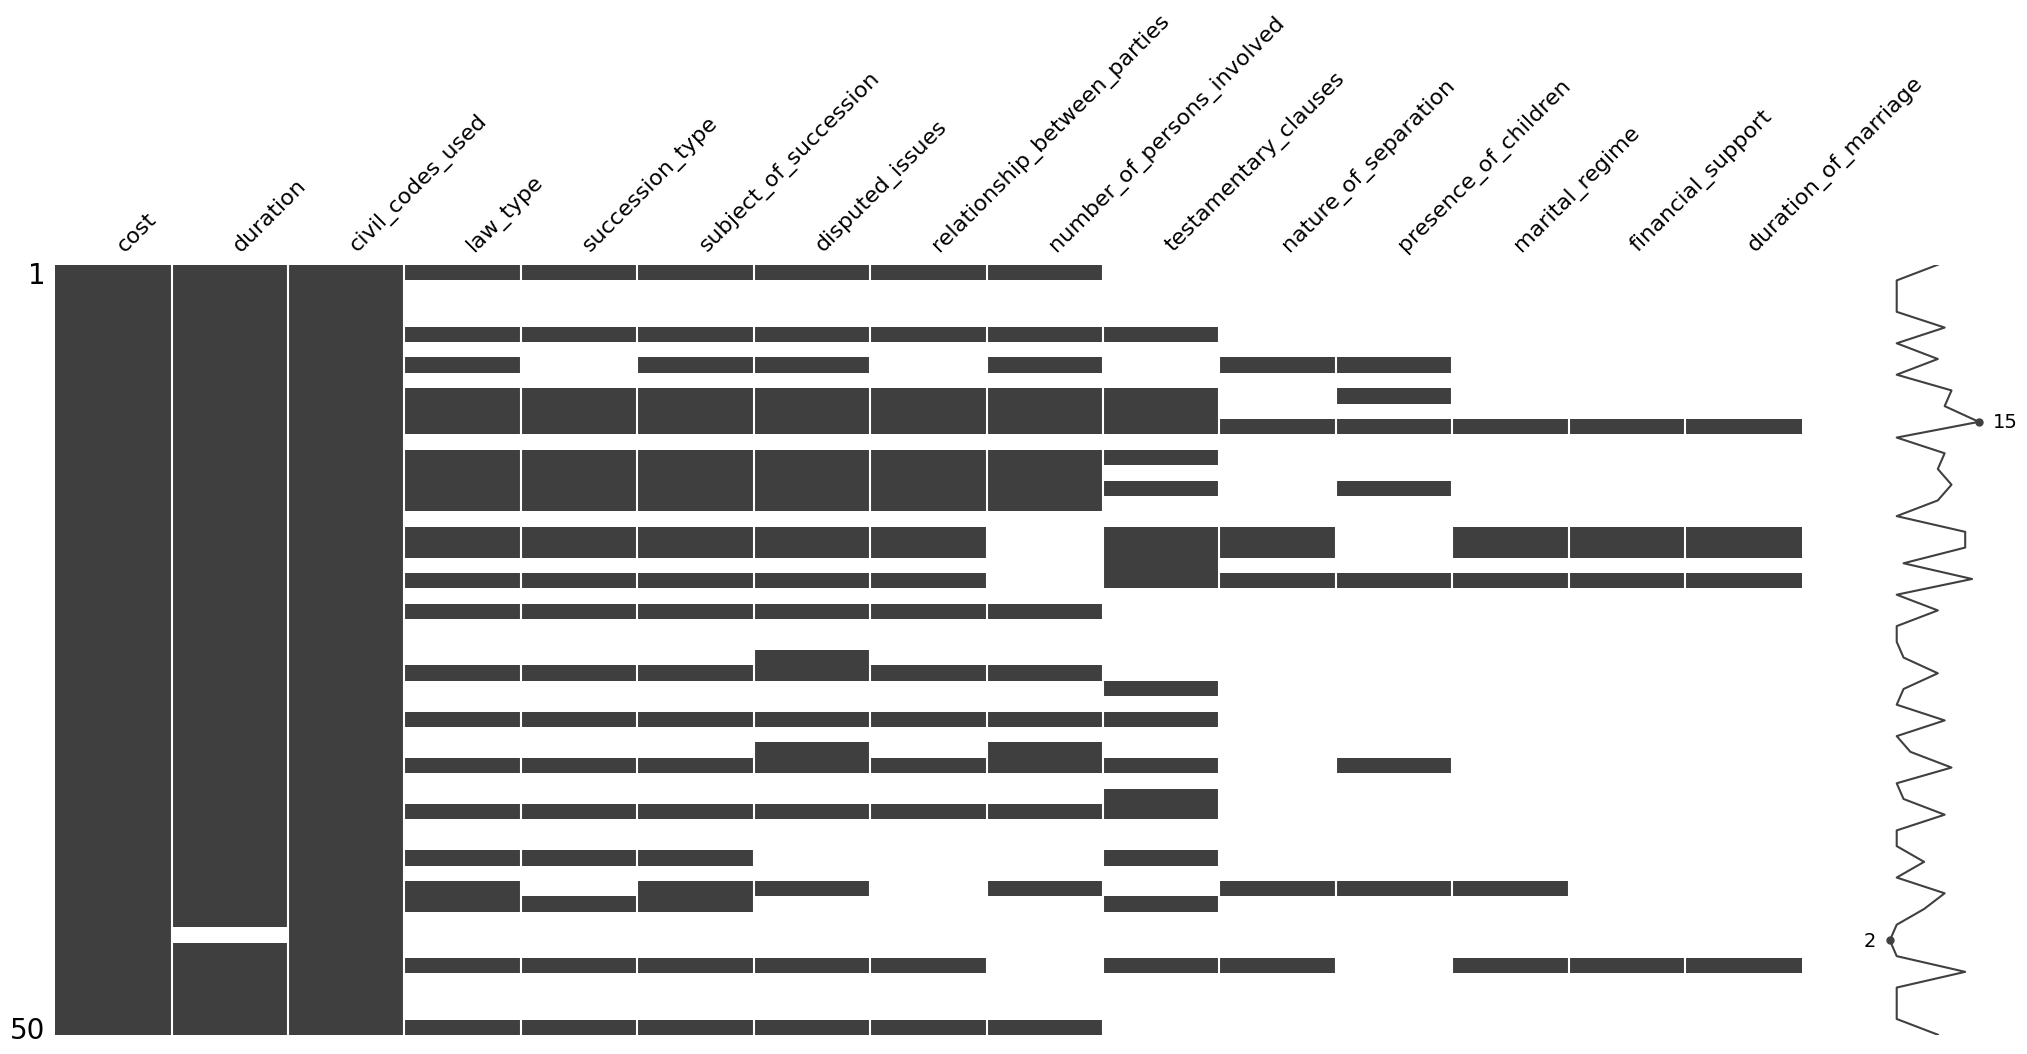

In [30]:
msno.matrix(total_metadata)

<Axes: >

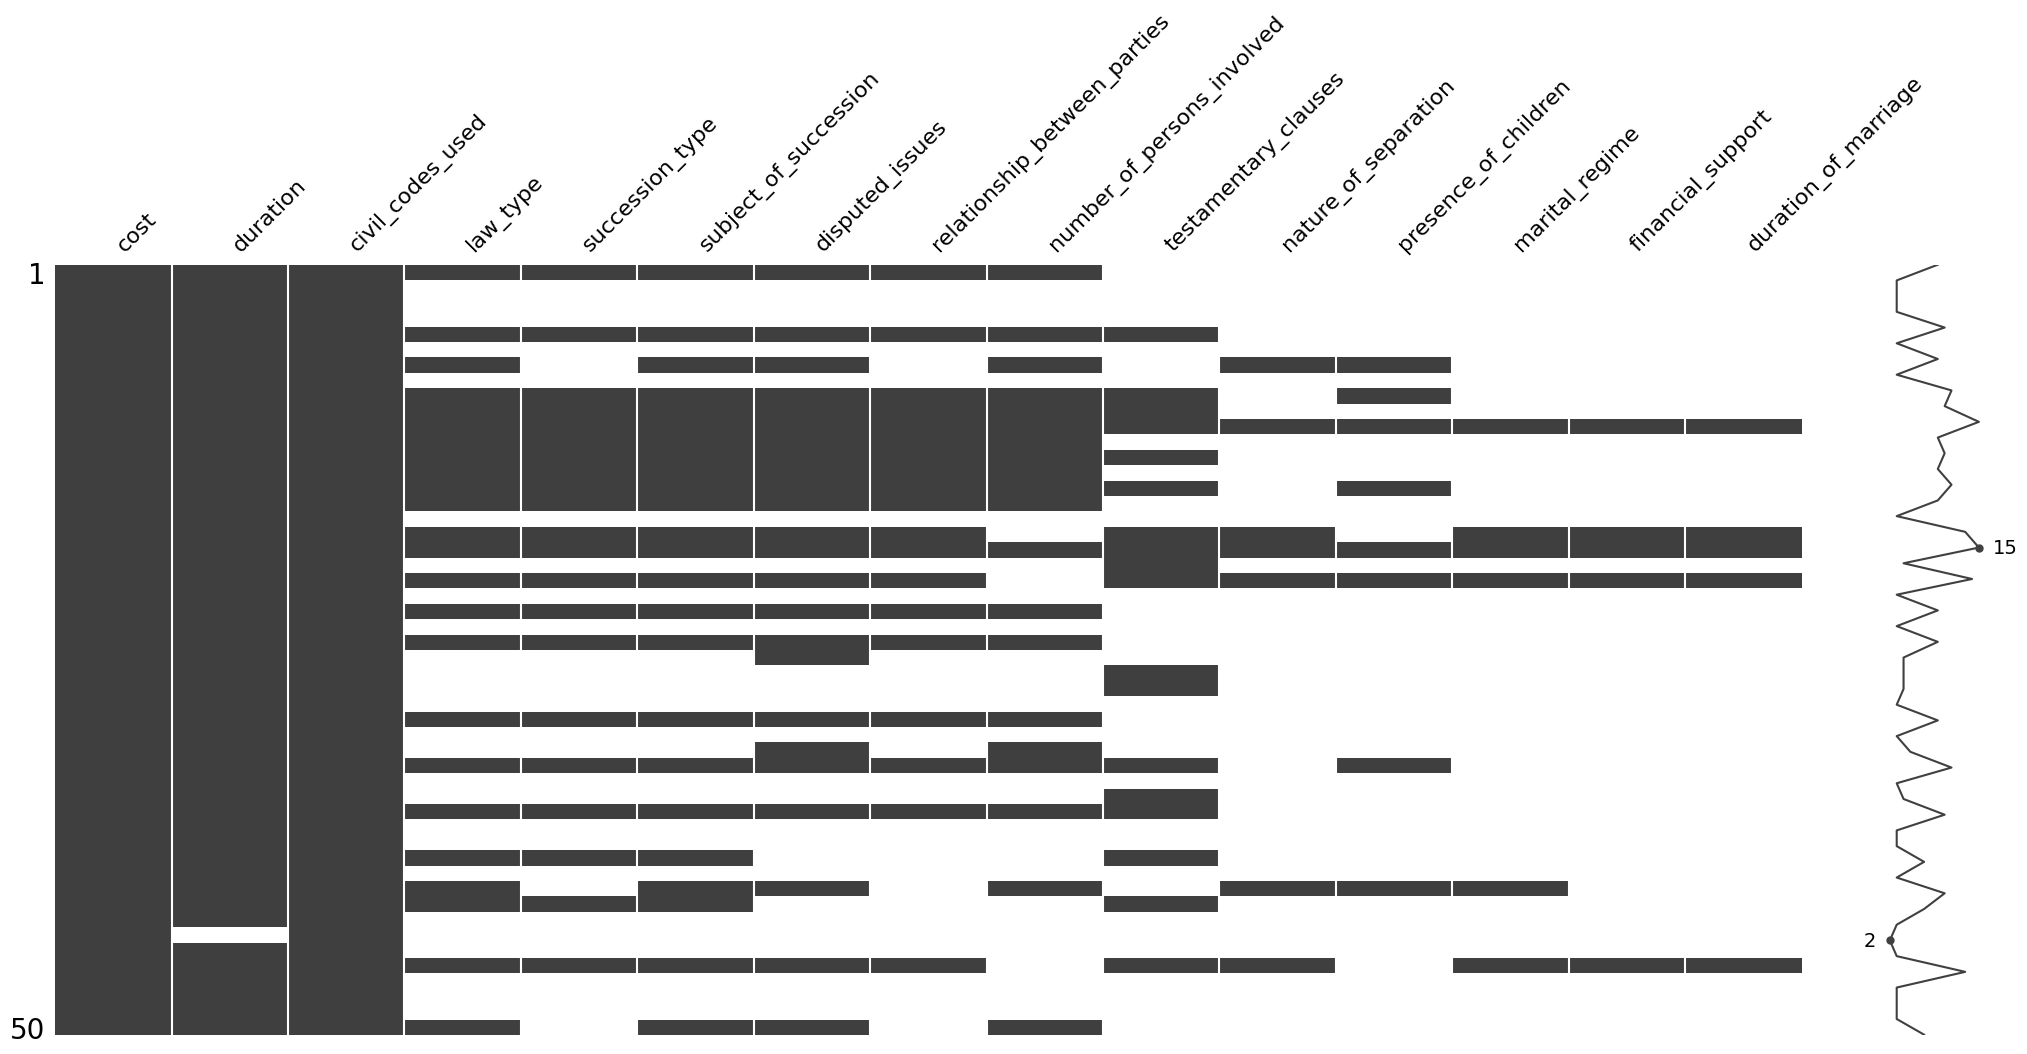

In [73]:
msno.matrix(df1)

# Preprocessing of data (Fixed)

In [2]:
import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langchain_community.document_transformers.openai_functions import create_metadata_tagger
from langchain_core.documents import Document as LangChainDocument
from langchain_openai import ChatOpenAI

import zipfile
from docx import Document
import os
import json
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dummy imports for demonstration; replace with your actual library imports
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')

class Processor:
    def __init__(self, zip_path, output_dir='output_json'):
        self.zip_path = zip_path
        self.output_dir = output_dir
        self.document_stopwords = [
            "COST OF PROCEDURE",
            "DURATION OF PROCEDURE",
            "FINAL RESOLUTION",
            "PRINCIPLES OF LAW USED FOR THE DECISION",
            "JUDGMENT",
            "LEGAL REASONS",
            "P.Q.M"
        ]
        self.nltk_stopwords = set(stopwords.words('english'))
        os.makedirs(self.output_dir, exist_ok=True)
        
        # # Define prompts for each specific section to summarize
        # prompt_legal_reasons = """Write a long as you  summary of the following text, take in account that this is legal text explaining the progress of a cause, try to summarize 
        # each step of it in a proper way (when you encounter omiss , it means that the name is anonymized  so don't care), latest ,(don't give me the name , but just identify the parties) 
        # talk in first person like you are part of it  in present time

        # ):
        # "{text}"
        # SUMMARY:"""
        
        #2nd template 
        # Define prompts for each specific section to summarize
        prompt_legal_reasons = """Write a short as you  summary of the following text, take in account that this is legal text explaining the progress of a cause, try to summarize 
        each step of it in a proper way (when you encounter omiss , it means that the name is anonymized  so don't care), i repeat,(don't give me the name , but just identify the parties) 
        talk as u are explaining it to a not legal person , do not make an introduction , directly summarize it in a clear way

        ):
        "{text}"
        SUMMARY:"""

        llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
        self.llm_chain_legal_reasons = LLMChain(llm=llm, prompt=PromptTemplate.from_template(prompt_legal_reasons))
        


        # Define the schema for metadata tagging
        schema = {
            "properties": {
                "cost": {"type": "string", "description": "Cost associated with the legal procedure. give me back just the value followed by €" },
                "duration": {"type": "string", "description": "Duration of the legal procedure. give me back just the duration using years or months "},
                "civil_codes_used": {"type": "array", "items": {"type": "string"}, "description": "List of civil codes referenced in the document return in this format art. (number of article), "},
                "law_type": {"type": "string", "enum": ["Succession", "Divorce"], "description": "Type of law the document pertains to (Succession or Divorce only) "},
                "succession_type": {"type": "string","enum": ["testamentary", "legal"], "description": "differentiates between testamentary succession (with a will) and legal succession (without a will)"},
                "subject_of_succession": {"type": "string", "description": "Filters by type of inheritance assets involved (real estate, bank accounts, company shares, etc.) be very concise"},
                "testamentary_clauses": {"type": "array", "items": {"type": "string"}, "description": "Specific testamentary clauses mentioned for example, legacies, trusts, or clauses excluding from inheritance (e.g. 			         disinheritance,clause) "},
                "disputed_issues": {"type": "array", "items": {"type": "string"},"enum": ["validity of will", "division of assets" , "legitimacy"], "description": "This section identifies specific disputes, such as the validity of a will, 	         the division of assets, or questions of legitimacy"},
                "relationship_between_parties": {"type": "string", "description": "Relationship between heir and de cuius "},
                "number_of_persons_involved": {"type": "integer", "description": "Number of heirs and/or legatees."},
                "nature_of_separation": {"type": "string", "enum": ["Voluntary", "Judicial","consensual" , "contentious"], "description": "Nature of separation, e.g., voluntary, judicial"},
                "presence_of_children": {"type": "boolean", "description": "Indicates if children are involved whether issues with the maintainance, custody ,visitation rights."},
                "marital_regime": {"type": "string","enum": ["community of property", "separation of property","issues relatively division of common properties" ], "description": "Marital regime affecting the separation/divorce and issues 	         relatively common properties."},
                "financial_support": {"type": "string", "description": "Details about alimony or spousal maintenance give me back just the value followed by €"},
                "duration_of_marriage": {"type": "string", "description": "Duration of the marriage being dissolved.give me back just the duration using years or months"},
            },
            "required": ["keyword", "text"]
        }


        self.document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm)
        self.original_documents = []  # To store original document texts   ADDED
        self.document_metadata = []  # To store metadata for each document   ADDED
        
        self.original_metadata = [] #metadata Added
        self.summary_metadata = []
        self.final_metadata = []
        
    def extract_zip(self):
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            zip_ref.extractall("extracted_docs")

    def process_documents(self):
        self.extract_zip()
        files = glob.glob('extracted_docs/**/*.docx', recursive=True)
        for file in files:
            self.process_file(file)
            
            


    def process_file(self, file_path):
        doc = Document(file_path)
        full_text = [para.text for para in doc.paragraphs if para.text.strip() != '']
        if not full_text:
            return
        
        text = "\n".join(full_text)
        self.original_documents.append({"file_path": file_path, "text": text})
        
        # Process original document
        original_document = LangChainDocument(page_content=text)
        enhanced_document = self.document_transformer.transform_documents([original_document])[0]
        self.original_metadata.append({"file_path": file_path, "metadata": enhanced_document.metadata})
        
        # Process summarized content
        structured_chunks = self.split_and_structure_text(text)
        summaries = self.summarize_document(structured_chunks)
        summary_document = LangChainDocument(page_content=summaries)
        summary_metadata = self.document_transformer.transform_documents([summary_document])[0].metadata
        self.summary_metadata.append({"file_path": file_path, "metadata": summary_metadata})
        
        # Merge metadata
        final_metadata = self.merge_metadata(enhanced_document.metadata, summary_metadata)
        self.final_metadata.append({"file_path": file_path, "metadata": final_metadata})
        
        # Save the final content with updated metadata
        self.save_as_json(final_metadata, structured_chunks, file_path, summaries)

        

        
        # Usage in the `process_file` method
        final_metadata = self.merge_metadata(enhanced_document.metadata, summary_metadata)

        # Save the final content with updated metadata
        self.save_as_json(final_metadata, structured_chunks, file_path, summaries)
        
    def merge_metadata(self, enhanced, summary):
        final_metadata = {}
        all_keys = set(enhanced.keys()).union(summary.keys())
        
        for key in all_keys:
            enhanced_value = enhanced.get(key)
            summary_value = summary.get(key)
            final_metadata[key] = summary_value if enhanced_value is None else enhanced_value

        # Check and update law_type based on specified conditions
        succession_related_keys = ['succession_type', 'subject_of_succession', 'disputed_issues', 
                                   'relationship_between_parties', 'number_of_persons_involved', 
                                   'testamentary_clauses']
        # Check and update law_type based on specified conditions
        divorce_related_keys = ['nature_of_separation', 'presence_of_children',
       'marital_regime', 'financial_support', 'duration_of_marriage']
        if final_metadata.get('law_type') is None and any(final_metadata.get(k) is not None for k in succession_related_keys):
            final_metadata['law_type'] = 'Succession'
        if final_metadata.get('law_type') is None and any(final_metadata.get(k) is not None for k in divorce_related_keys):
                final_metadata['law_type'] = 'Divorce'
        
        return final_metadata
    
    def get_metadata_dataframes(self):
        # Convert stored metadata lists to dataframes
        original_df = pd.DataFrame([m['metadata'] for m in self.original_metadata])
        summary_df = pd.DataFrame([m['metadata'] for m in self.summary_metadata])
        final_df = pd.DataFrame([m['metadata'] for m in self.final_metadata])
        return original_df, summary_df, final_df
        

    def save_as_json(self, metadata, structured_chunks, file_path, summaries):
        base_name = os.path.basename(file_path)
        json_filename = os.path.splitext(base_name)[0] + '.json'
        json_path = os.path.join(self.output_dir, json_filename)
        
        document_structure = {
            "content": summaries,
            "metadata": metadata
        }
        
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(document_structure, f, ensure_ascii=False, indent=4)
            
    def split_and_structure_text(self, text):
        structured_chunks = []
        current_pos = 0
        prev_stopword = "CASE_ID"
        for stopword in self.document_stopwords:
            stopword_pos = text.find(stopword, current_pos)
            if stopword_pos != -1:
                chunk = text[current_pos:stopword_pos].strip()
                if chunk:
                    structured_chunks.append({"keyword": prev_stopword, "text": self.clean_data(chunk)})
                current_pos = stopword_pos + len(stopword)
                prev_stopword = stopword
        final_chunk = text[current_pos:].strip()
        if final_chunk:
            structured_chunks.append({"keyword": prev_stopword, "text": self.clean_data(final_chunk)})
        return structured_chunks

    def clean_data(self, text_chunk):
        tokens = word_tokenize(text_chunk)
        filtered_tokens = [token for token in tokens if token.lower() not in self.nltk_stopwords]
        cleaned_text = " ".join(filtered_tokens)
        return cleaned_text

    def summarize_document(self, structured_chunks):
        # Initialize a list to hold summaries of each chunk.
        chunk_summaries = []

        # Iterate over each chunk and summarize it.
        for chunk in structured_chunks:
            text_for_summarization = chunk["text"]
            # Assume `self.llm_chain_general.run()` is a method to summarize a given text.
            # This method should be adjusted according to your setup.
            summary = self.llm_chain_legal_reasons.run({"text": text_for_summarization})
            chunk_summaries.append(summary)

        # Unify all chunk summaries into a single comprehensive summary.
        # This could be as simple as concatenating them, or you might choose a more complex approach.
        # For simplicity, let's concatenate the summaries.
        unified_summary = " ".join(chunk_summaries)
        summary = self.llm_chain_legal_reasons.run(unified_summary)
        # The final summaries dictionary now only includes the unified summary.
        summaries = {"progress": unified_summary}

        return summary


    def save_as_json(self, metadata, structured_chunks, file_path, summaries):
        base_name = os.path.basename(file_path)
        json_filename = os.path.splitext(base_name)[0] + '.json'
        json_path = os.path.join(self.output_dir, json_filename)
        
        # Now 'content' only contains the unified summary, no need to filter or append anything
        content = summaries
        
        # The final document structure includes only 'content' and 'metadata'
        document_structure = {
            "content": content,
            "metadata": metadata
        }
        
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(document_structure, f, ensure_ascii=False, indent=4)

    # ADDED
    def get_documents_with_metadata(self):
        """
        Returns a list of documents with their original text and associated metadata.
        """
        augmented_documents = []
        for doc, metadata in zip(self.original_documents, self.document_metadata):
            augmented_document = {
                "file_path": doc["file_path"],
                "original_text": doc["text"],
                "metadata": metadata["metadata"]
            }
            augmented_documents.append(augmented_document)
        return augmented_documents
    
    # ADDED
    def extract_filters_from_query(self, query):
        # Initial tagger application on the whole document
        original_query = LangChainDocument(page_content=query)
        enhanced_query = self.document_transformer.transform_documents([original_query])
        return enhanced_query





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALBER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALBER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import pandas as pd
# Example usage
zip_path = 'C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Sentenze.zip'
output_dir = 'C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs_Final_Merged_ex'
processor = Processor(zip_path, output_dir)
processor.process_documents()
documents_with_metadata = processor.get_documents_with_metadata()
# Retrieve the metadata in DataFrame formata
original_metadata_df_1, summary_metadata_df_1, final_metadata_df_merged_1 = processor.get_metadata_dataframes()

In [16]:
# Specify the desired column order
column_order = [
    'cost', 'duration', 'civil_codes_used', 'law_type', 'succession_type',
    'subject_of_succession', 'disputed_issues', 'relationship_between_parties',
    'number_of_persons_involved', 'testamentary_clauses', 'nature_of_separation',
    'presence_of_children', 'marital_regime', 'financial_support', 'duration_of_marriage'
]

# Reorder the counts according to the specified column order
F = final_metadata_df_merged_1.reindex(columns=column_order)

<Axes: >

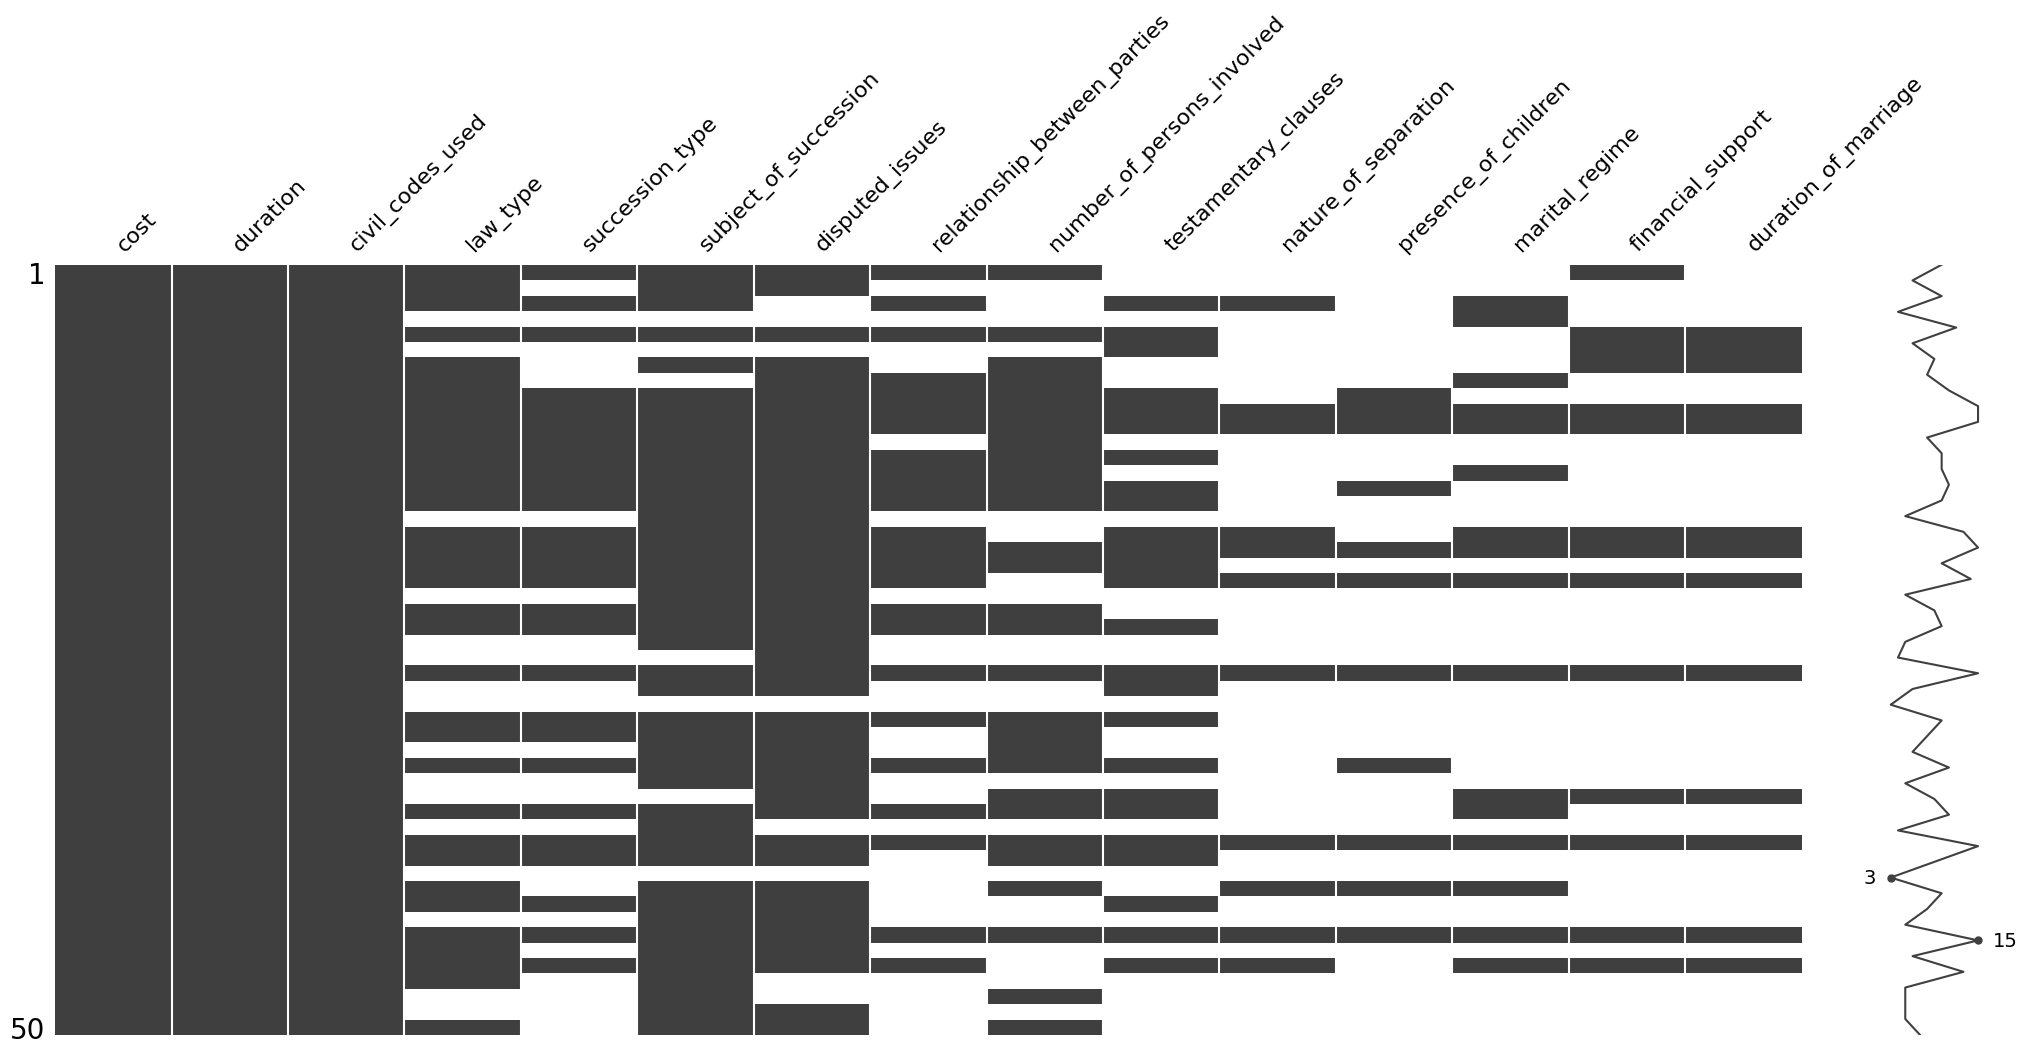

In [17]:

msno.matrix(F)

In [147]:
documents_with_metadata = processor.get_documents_with_metadata()

# Previous Analysis

In [62]:
final_null = final_metadata_df.isnull().sum().sum()
original_null = original_metadata_df.isnull().sum().sum()
summary_null = summary_metadata_df.isnull().sum().sum()

In [121]:
final_metadata_df["law_type"].count()

35

In [63]:
print ( final_null ,original_null , summary_null)

299 422 489


In [91]:
original_metadata_df.columns

Index(['cost', 'duration', 'civil_codes_used', 'law_type', 'succession_type',
       'subject_of_succession', 'disputed_issues',
       'relationship_between_parties', 'number_of_persons_involved',
       'testamentary_clauses', 'nature_of_separation', 'presence_of_children',
       'marital_regime', 'financial_support', 'duration_of_marriage'],
      dtype='object')

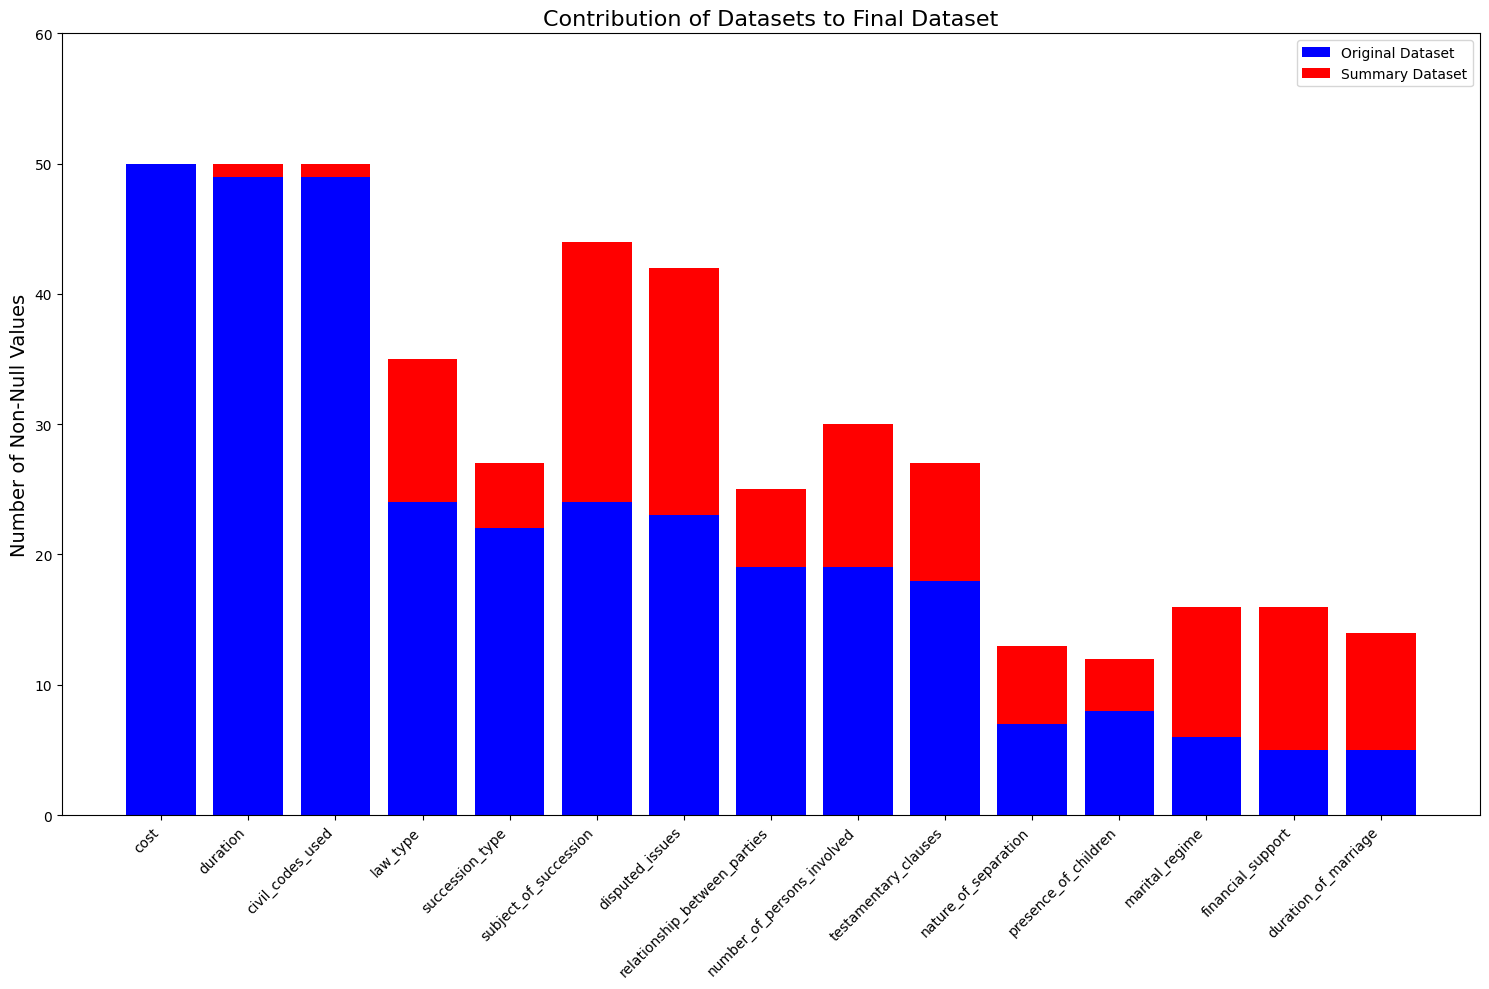

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_metadata_df, original_metadata_df, and summary_metadata_df are your DataFrames

# Calculate non-null intersection with final_metadata_df
common_with_original = final_metadata_df.notnull() & original_metadata_df.notnull()

# Calculate non-null intersection with final_metadata_df that is not in original_metadata_df
common_with_summary = final_metadata_df.notnull() & summary_metadata_df.notnull() & ~original_metadata_df.notnull()

# Sum up the True values which represent non-null intersections
original_non_null_count = common_with_original.sum()
summary_non_null_count = common_with_summary.sum()  # Only non-nulls from summary not in original

# Specify the desired column order
column_order = [
    'cost', 'duration', 'civil_codes_used', 'law_type', 'succession_type',
    'subject_of_succession', 'disputed_issues', 'relationship_between_parties',
    'number_of_persons_involved', 'testamentary_clauses', 'nature_of_separation',
    'presence_of_children', 'marital_regime', 'financial_support', 'duration_of_marriage'
]

# Reorder the counts according to the specified column order
original_non_null_count = original_non_null_count.reindex(column_order)
summary_non_null_count = summary_non_null_count.reindex(column_order)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the bars for the original dataset
ax.bar(original_non_null_count.index, original_non_null_count, label='Original Dataset', color='blue')

# Plot the additional summary contributions on top of the original
ax.bar(summary_non_null_count.index, summary_non_null_count, bottom=original_non_null_count, label='Summary Dataset', color='red')

# Set the y-axis limit
ax.set_ylim(0, max(original_non_null_count.max(), summary_non_null_count.max()) + 10)  # Adjust based on your data

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adding labels and title
ax.set_ylabel('Number of Non-Null Values', fontsize=14)
ax.set_title('Contribution of Datasets to Final Dataset', fontsize=16)
ax.legend()

# Adjust the layout to make room for the x-axis labels
plt.tight_layout()
plt.show()


In [ ]:
# Specify the desired column order
column_order = [
    'cost', 'duration', 'civil_codes_used', 'law_type', 'succession_type',
    'subject_of_succession', 'disputed_issues', 'relationship_between_parties',
    'number_of_persons_involved', 'testamentary_clauses', 'nature_of_separation',
    'presence_of_children', 'marital_regime', 'financial_support', 'duration_of_marriage'
]

# Reorder the counts according to the specified column order
original_non_null_count = original_non_null_count.reindex(column_order)
summary_non_null_count = summary_non_null_count.reindex(column_order)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the bars for the original dataset
ax.bar(original_non_null_count.index, original_non_null_count, label='Original Metadata', color='lightblue')

# Plot the additional summary contributions on top of the original
ax.bar(summary_non_null_count.index, summary_non_null_count, bottom=original_non_null_count, label='Summary Metadata', color='lightred')

# Set the y-axis limit
ax.set_ylim(0, max(original_non_null_count.max(), summary_non_null_count.max()) + 10)  # Adjust based on your data

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adding labels and title
ax.set_ylabel('Number of Non-Null Values', fontsize=14)
ax.set_title('Contribution of Datasets to Final Dataset', fontsize=16)
ax.legend()

# Add a transparent dashed bar for the 'law_type' column
ax.bar('law_type', 48, color='none', edgecolor='black', linestyle='--', hatch='/', lw=1)

# Add a notation for "Logical Augmentation" with a smaller arrow
ax.annotate('Logical Augmentation', xy=(3, 48), xytext=(3.5, 53),
            arrowprops=dict(facecolor='black', shrink=0.1))

# Adjust the layout to make room for the x-axis labels
plt.tight_layout()
plt.show()

# Merged Analysis

<Axes: >

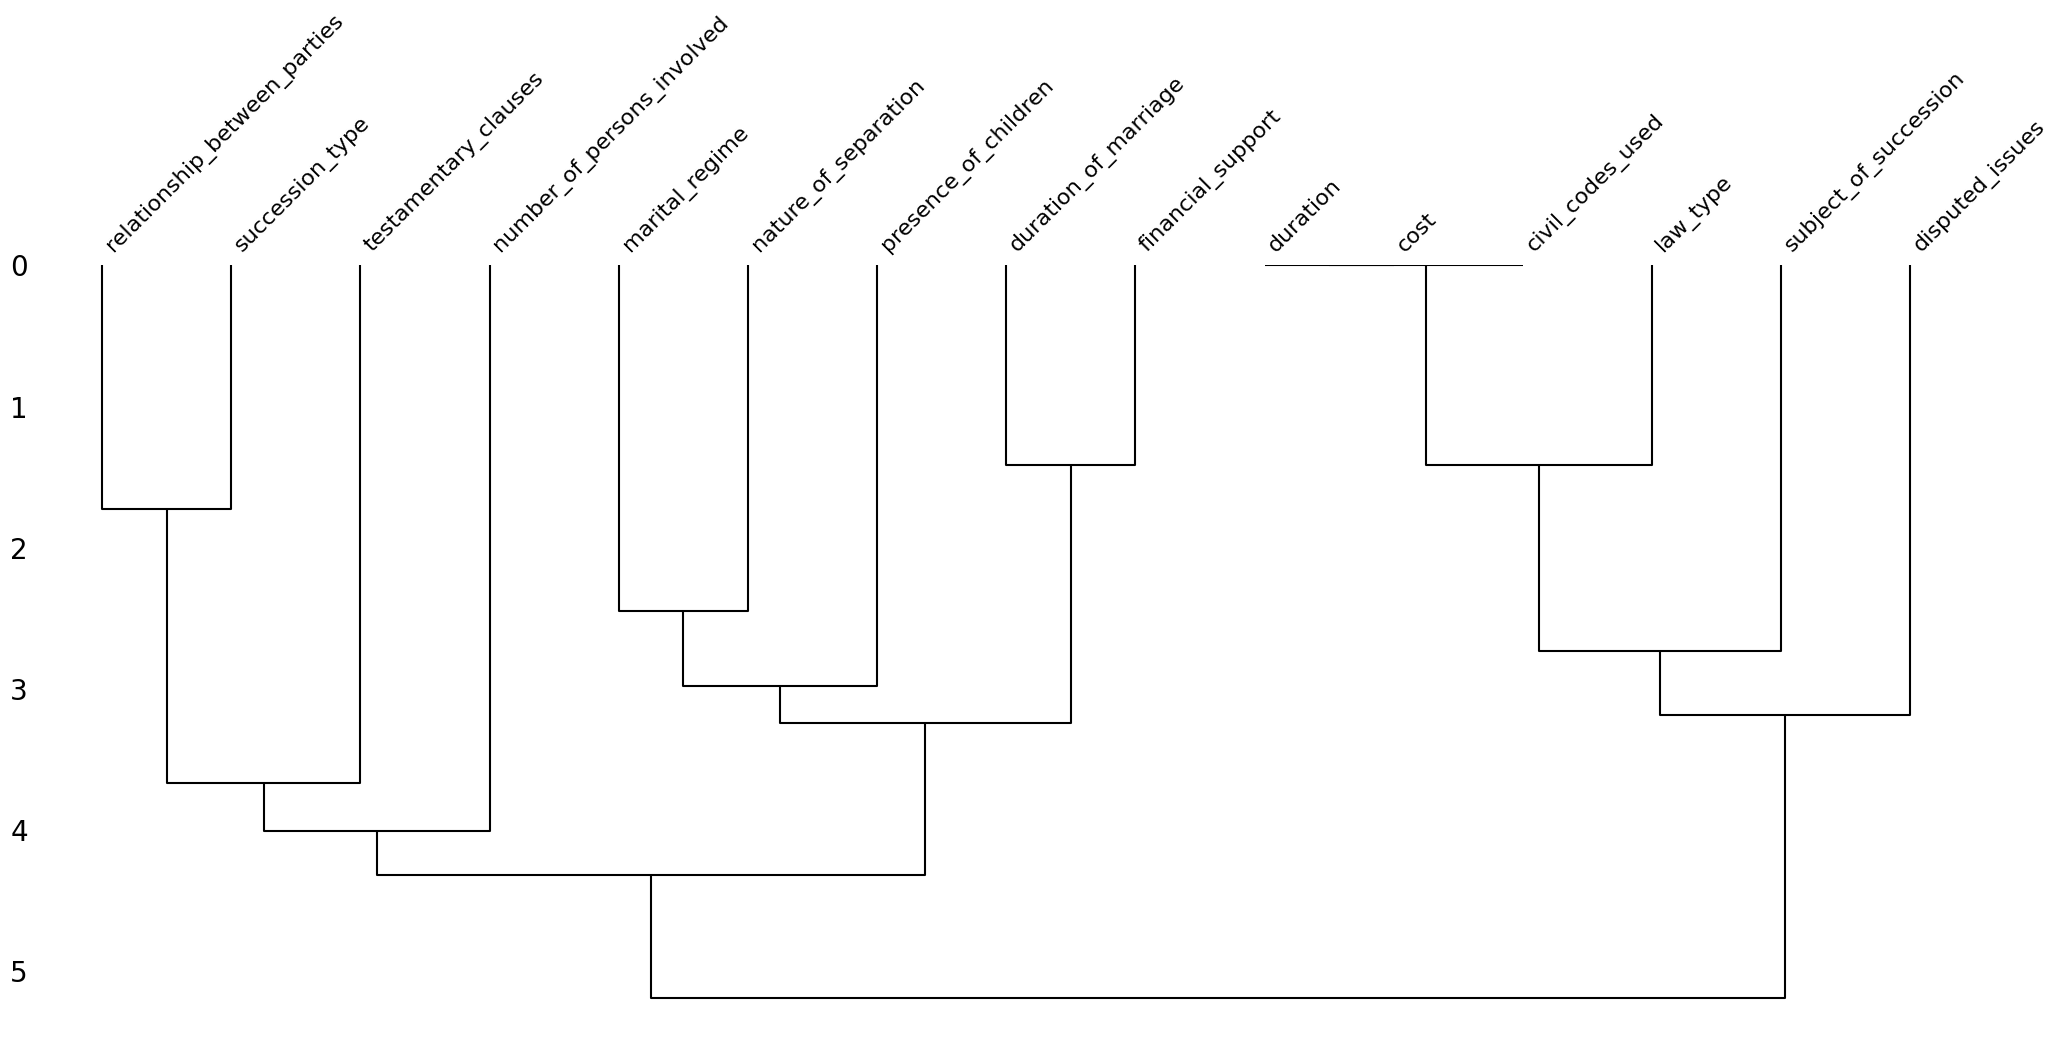

In [141]:
import missingno as msno
final_metadata_df_merged["law_type"].count()
# Reorder columns in original_df
final_metadata_df_merged = final_metadata_df_merged.reindex(columns=['cost', 'duration', 'civil_codes_used', 'law_type', 'succession_type',
       'subject_of_succession', 'disputed_issues',
       'relationship_between_parties', 'number_of_persons_involved',
       'testamentary_clauses', 'nature_of_separation', 'presence_of_children',
       'marital_regime', 'financial_support', 'duration_of_marriage'])
msno.dendrogram(final_metadata_df_merged)

In [17]:
import missingno as msno
msno.matrix(final_metadata_df_merged)

NameError: name 'final_metadata_df_merged' is not defined

In [ ]:
import os
import json

def save_documents_with_metadata_as_json(documents_with_metadata, output_dir):
    """
    Saves documents along with their metadata in JSON format in the specified output directory.
    Each document's data is saved in a separate JSON file named after the document's base filename.
    
    Parameters:
    - documents_with_metadata: A list of dictionaries, where each dictionary contains the file path,
      original text, and metadata of a document.
    - output_dir: The directory where the JSON files will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for document in documents_with_metadata:
        # Extract the filename without the extension and add .json
        base_name = os.path.basename(document["file_path"])
        json_filename = os.path.splitext(base_name)[0] + '.json'
        json_path = os.path.join(output_dir, json_filename)
        
        # Prepare the document data for JSON serialization
        document_data = {
            "original_text": document["original_text"],
            "metadata": document["metadata"]
        }
        
        # Save the document data as JSON
        with open(json_path, 'w', encoding='utf-8') as json_file:
            json.dump(document_data, json_file, ensure_ascii=False, indent=4)
            
    print(f"All documents with metadata have been saved to JSON files in {output_dir}.")

# Example usage:
# Assuming `processor` is an instance of your Processor class and has processed some documents
documents_with_metadata = processor.get_documents_with_metadata()
output_directory = 'C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/doc_with_metadata'
save_documents_with_metadata_as_json(documents_with_metadata, output_directory)


All documents with metadata have been saved to JSON files in C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/doc_with_metadata.


# Exploratory data analysis of original documents

In [146]:
from langchain_core.documents import Document as LangChainDocument

def transform_to_langchain_documents(documents_with_metadata):
    """
    Transforms a list of document dictionaries (with original text and metadata) 
    into LangChain Document objects.

    Parameters:
    - documents_with_metadata: A list of dictionaries, each containing at least 'file_path', 
      'original_text', and 'metadata' keys.

    Returns:
    A list of LangChainDocument objects, each corresponding to a document in the input list.
    """
    langchain_documents = []
    for document in documents_with_metadata:
        # Create a LangChainDocument object for each document
        # Assuming 'page_content' is where you want to store the 'original_text'
        # and 'metadata' is directly applicable as metadata in LangChainDocument
        lc_document = LangChainDocument(
            page_content=document["original_text"],
            metadata=document.get("metadata", {})
        )
        langchain_documents.append(lc_document)
    
    return langchain_documents

# Example usage:
# Assuming `documents_with_metadata` is populated
lc_documents = transform_to_langchain_documents(documents_with_metadata)


In [145]:
lc_documents

[]

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from langchain_openai import OpenAIEmbeddings
import os
import seaborn as sns 


class Explorer:
    def __init__(self, api_key):
        self.embedder = OpenAIEmbeddings(api_key=api_key)

    def preprocess_data(self, docs):
        """
        Preprocess text data from documents, extracting page content and collecting metadata.

        Args:
            docs (list): A list of document objects with 'page_content' and 'metadata'.

        Returns:
            tuple: A tuple containing a list of cleaned document texts and a list of metadata dictionaries.
        """
        cleaned_all_docs = [doc.page_content.strip() for doc in docs]
        metadata_list = [doc.metadata for doc in docs]  # Assume each doc has metadata
        print(metadata_list)
        return cleaned_all_docs, metadata_list

    def get_embeddings(self, texts):
        """
        Embeds a list of document texts using the OpenAI Embeddings API.

        Args:
            texts (list): Texts to embed.

        Returns:
            numpy.ndarray: An array of embeddings.
        """
        return np.array(self.embedder.embed_documents(texts))

    def detect_outliers(self, embeddings):
        """
        Detects outliers in the embeddings using Isolation Forest.

        Args:
            embeddings (numpy.ndarray): Embeddings matrix.

        Returns:
            numpy.ndarray: Predictions from Isolation Forest, where -1 indicates outliers and 1 indicates inliers.
        """
        iso_forest = IsolationForest(contamination='auto', random_state=42)
        preds = iso_forest.fit_predict(embeddings)
        return preds

    def plot_embeddings_and_variance(self, cleaned_all_docs, metadata_list):
        """
        Embeds documents, performs PCA, plots explained variance, visualizes embeddings in 3D in a 1x2 grid layout:
        - The first subplot shows all documents with outliers marked.
        - The second subplot shows documents with non-null law_type metadata in two colors based on their law_type.
        This method also separates metadata of outliers and inliers into two pandas DataFrames.

        Args:
            cleaned_all_docs (list): List of cleaned document texts.
            metadata_list (list): List of corresponding metadata dictionaries.
        """
        all_docs_emb = self.get_embeddings(cleaned_all_docs)
        
        # Apply PCA to see explained variance with 10 components
        pca_var = PCA(n_components=10)
        pca_var.fit(all_docs_emb)
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, 11), pca_var.explained_variance_ratio_, alpha=0.7, label='Individual explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.title('Explained Variance by Different Principal Components')
        plt.show()

        # Reduce embeddings to 3 dimensions for visualization
        pca_3d = PCA(n_components=3)
        reduced_embeddings = pca_3d.fit_transform(all_docs_emb)

        # Detect outliers
        preds = self.detect_outliers(reduced_embeddings)

        # Separate outlier and inlier indices
        outlier_indices = np.where(preds == -1)[0]
        inlier_indices = np.where(preds == 1)[0]

        # Extract metadata for outliers and inliers
        outlier_metadata = [metadata_list[i] for i in outlier_indices]
        inlier_metadata = [metadata_list[i] for i in inlier_indices]
        total_metadata = metadata_list

        # Create DataFrames
        outlier_metadata_df = pd.DataFrame(outlier_metadata)
        inlier_metadata_df = pd.DataFrame(inlier_metadata)
        total_metadata_df = pd.DataFrame(total_metadata)

        # Setting up the figure for a 1x2 grid of 3D plots
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(121, projection='3d')  # First subplot
        ax2 = fig.add_subplot(122, projection='3d')  # Second subplot

        # Plotting in 3D for all documents in the first subplot
        ax1.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c='blue', marker='o', label='All Documents')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        ax1.set_title('All Documents')

        # Filter documents with non-null law_type and categorize based on their law_type for the second subplot
        law_type_indices = [i for i, meta in enumerate(metadata_list) if meta.get('law_type') is not None]
        print(law_type_indices)
        law_type_categories = [metadata_list[i].get('law_type') for i in law_type_indices]
        print(law_type_categories)
        unique_law_types = list(set(law_type_categories))
        print(unique_law_types)

        # Assuming len(unique_law_types) checks and color mapping setup are done earlier

        # Adjusted section for filtering 'Succession' and 'Divorce' law types
        relevant_law_types = ['Succession', 'Divorce']  # Specify the relevant law types
        filtered_law_type_indices = [i for i, lt in zip(law_type_indices, law_type_categories) if lt in relevant_law_types]
        filtered_law_type_categories = [lt for lt in law_type_categories if lt in relevant_law_types]

        # You may want to adjust color mapping if you're specifically plotting only these two law types
        colors = ['red', 'green']
        law_type_color_map = dict(zip(relevant_law_types, colors))

        # Plotting in 3D for documents with 'Succession' and 'Divorce' law_type in the second subplot
        for law_type, color in law_type_color_map.items():
            indices = [i for i, lt in zip(filtered_law_type_indices, filtered_law_type_categories) if lt == law_type]
            ax2.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], reduced_embeddings[indices, 2], c=color, marker='o', label=law_type)

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        ax2.set_zlabel('PC3')
        ax2.set_title('Documents with Law Type Metadata: Succession and Divorce')
        ax2.legend()


        plt.show()

        # Return DataFrames for further analysis
        return outlier_metadata_df, inlier_metadata_df, total_metadata_df


    def count_words_distribution(self, cleaned_all_docs):
        """
        Counts words in each document and plots a distribution of word counts using Matplotlib.

        Args:
            cleaned_all_docs (list): List of cleaned document texts.

        Returns:
            list: A list of word counts for each document.
        """
        word_counts = [len(doc.split()) for doc in cleaned_all_docs]
        
        plt.figure(figsize=(10, 6))
        plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
        plt.title('Distribution of Document Word Counts')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.show()
        
        return word_counts


openai_api_key = os.getenv('OPENAI_API_KEY')  # Ensure your OpenAI API key is correctly set in your environment
explorer = Explorer(api_key=openai_api_key)

# Assuming `documents` is defined as a list of objects with 'page_content' and 'metadata'
cleaned_all_docs, metadata_list = explorer.preprocess_data(lc_documents)
# outliers_metadata_df, inliers_metadata_df, total_metadata = explorer.plot_embeddings_and_variance(cleaned_all_docs, metadata_list)
# word_coount = explorer.count_words_distribution(cleaned_all_docs)



Normal (Inlier) Documents Metadata:


<Axes: >

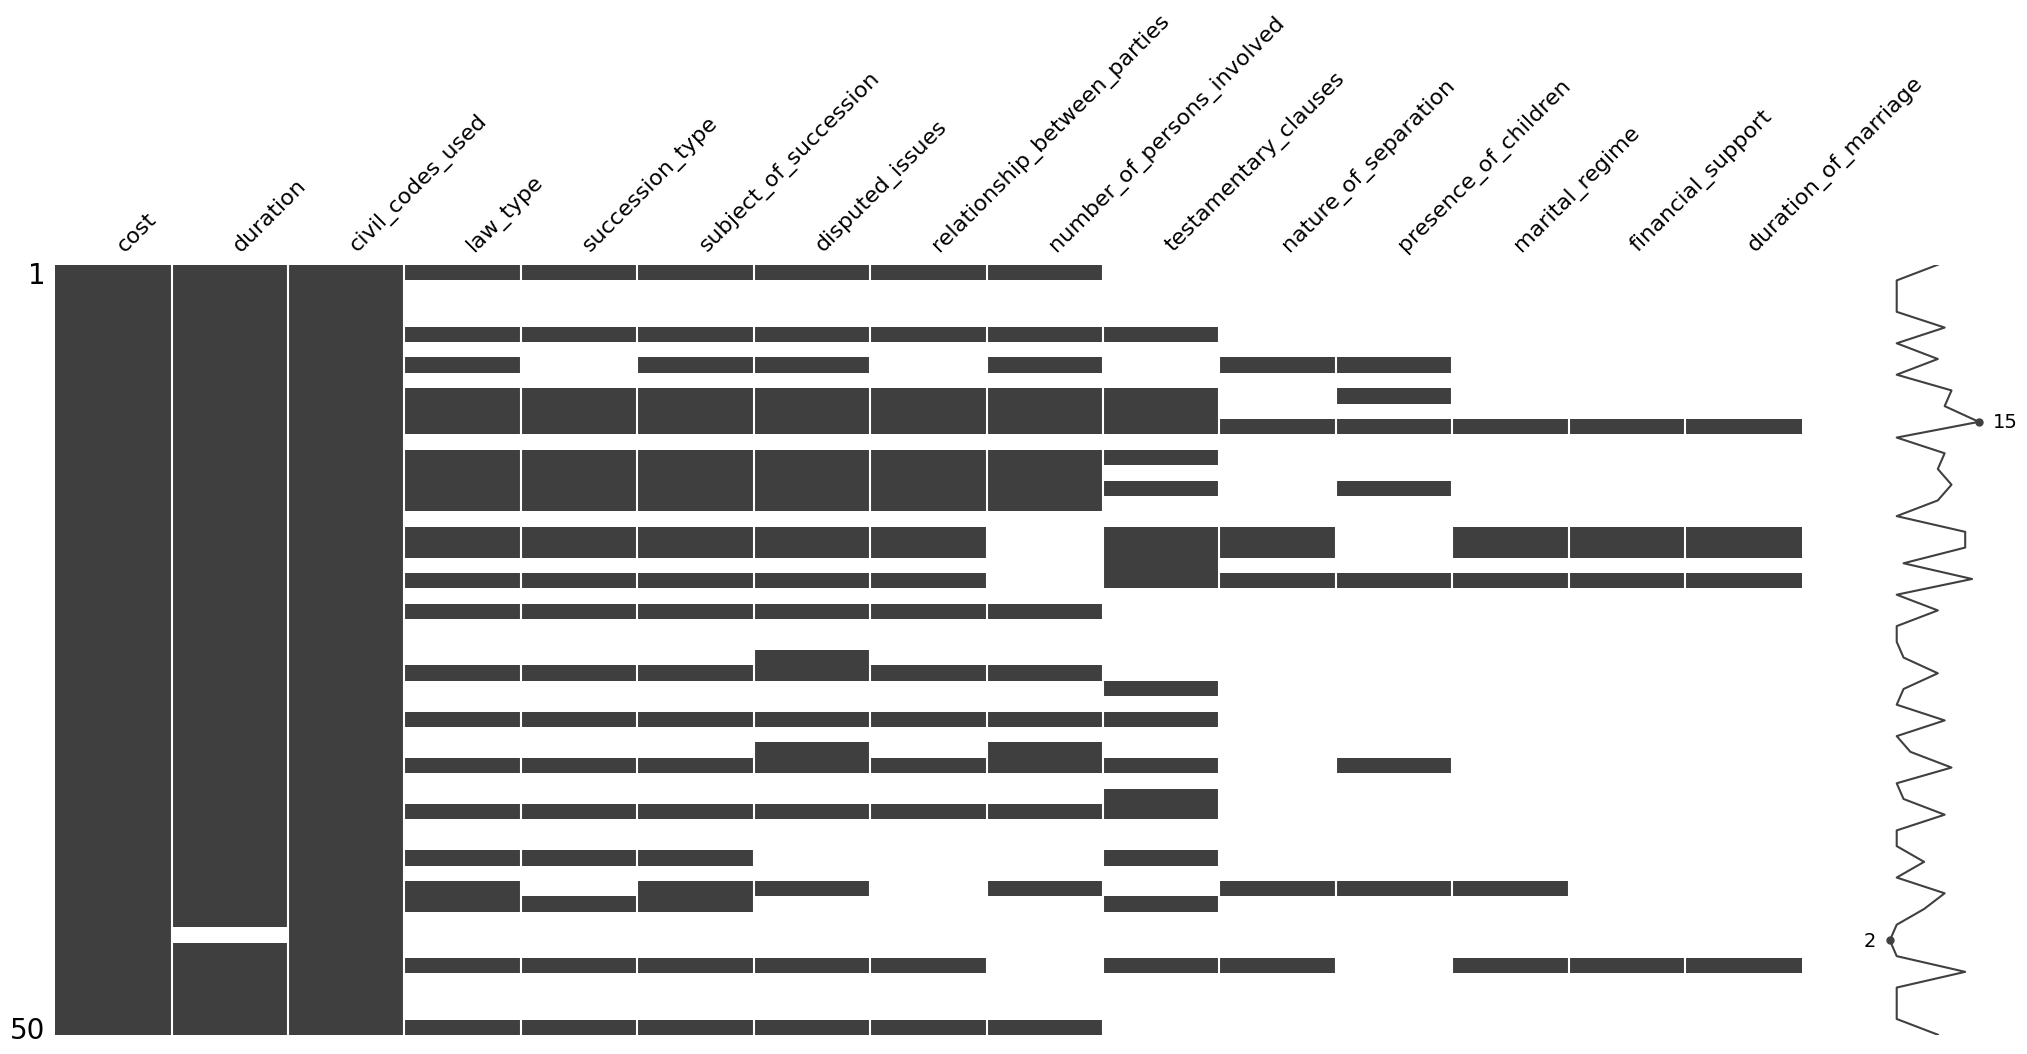

In [ ]:
import pandas as pd
import missingno as msno
print("\nNormal (Inlier) Documents Metadata:")
msno.matrix(total_metadata)


Normal (Inlier) Documents Metadata:


<Axes: >

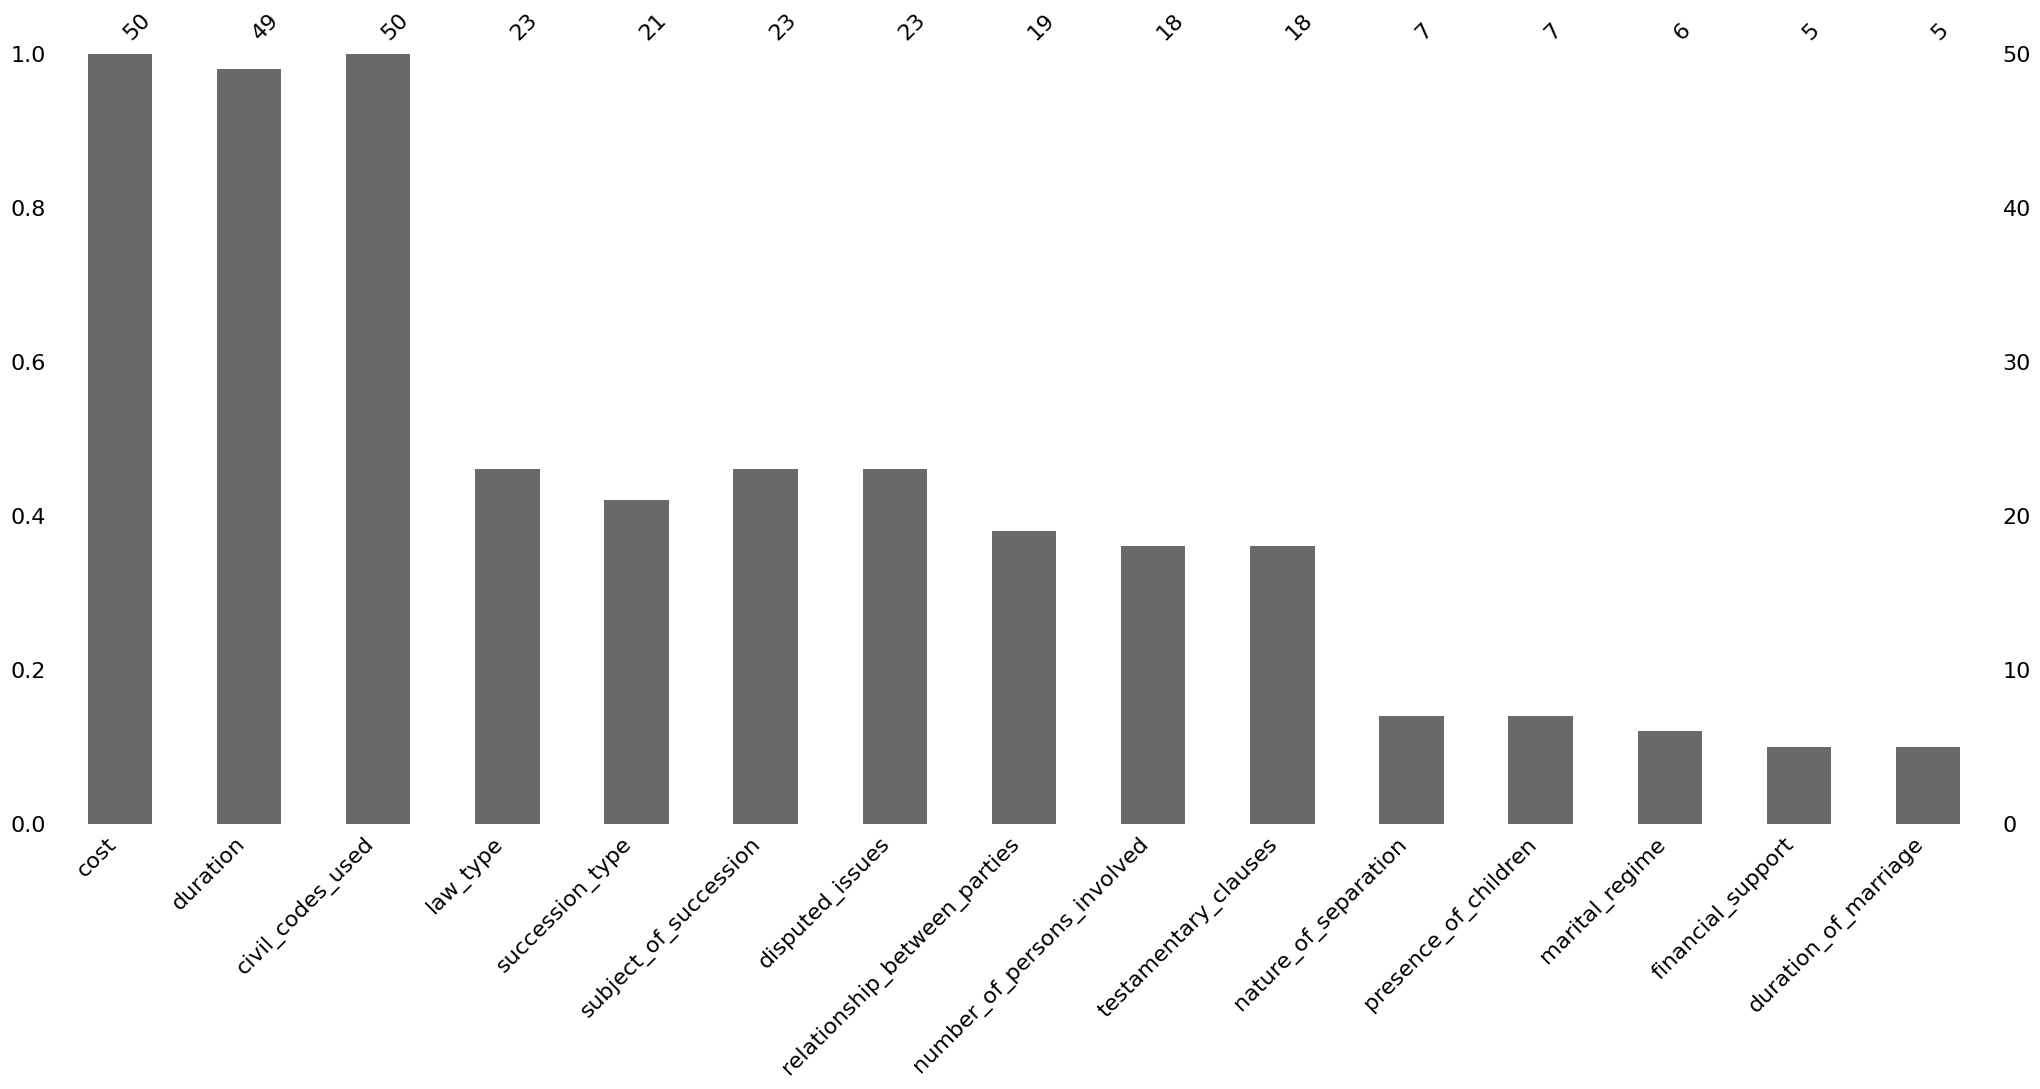

In [ ]:
import pandas as pd
import missingno as msno
print("\nNormal (Inlier) Documents Metadata:")
msno.bar(total_metadata)

In [ ]:
df=total_metadata
# Filtering out the documents that do not have law type 'Divorce' or 'Inheritance'
valid_law_types = ['Divorce', 'Succession']
filtered_df = df[df['law_type'].isin(valid_law_types)]

# Finding the indices of removed documents
removed_indices = df.index.difference(filtered_df.index).tolist()

len(removed_indices)


30

<Axes: >

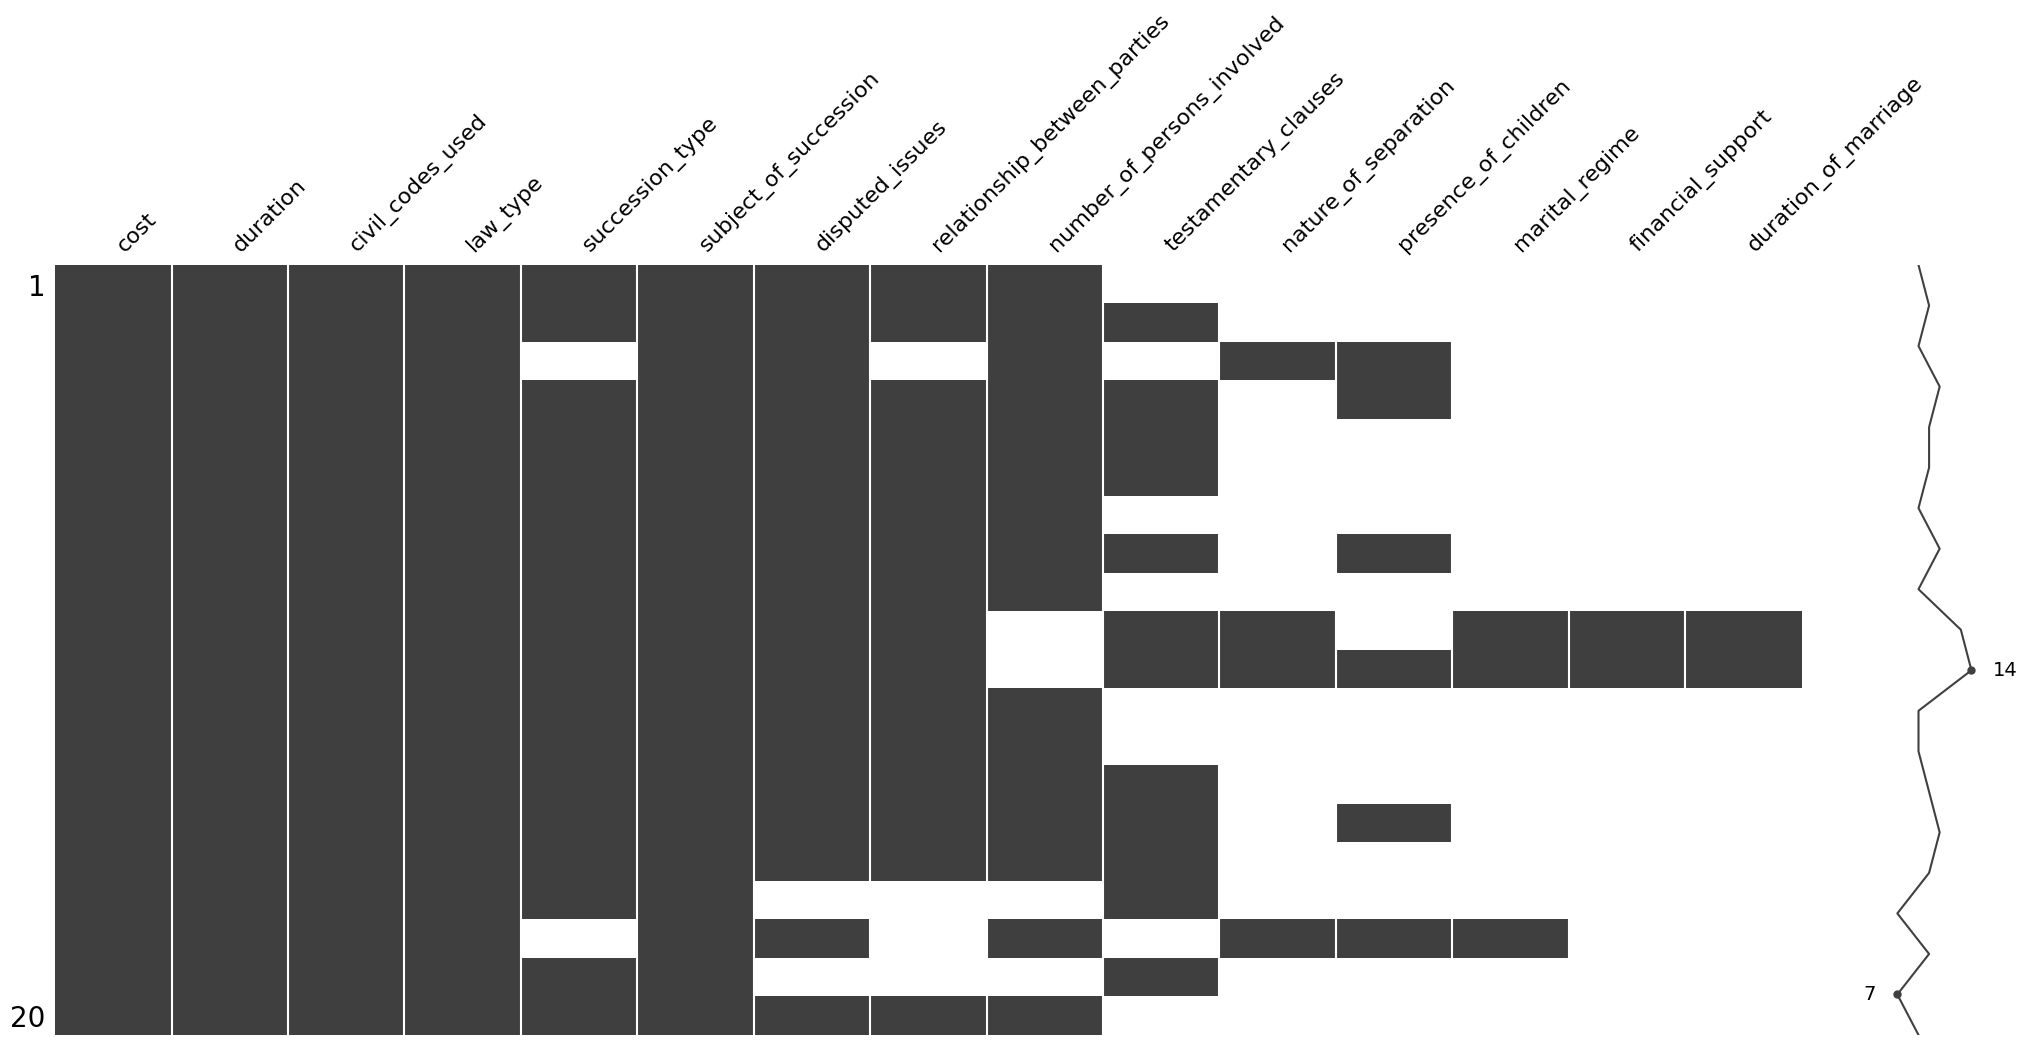

In [ ]:
msno.matrix(filtered_df)

# Retriever Class

In [21]:
import os
import json
from typing import List
from langchain_core.documents import Document  # Adjust import path as necessary
import numpy as np 
from langchain.embeddings import CacheBackedEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_community.vectorstores import FAISS

class Retriever:
    """
    A class designed to load enhanced documents from JSON, embed them, and create a searchable
    FAISS database. It encapsulates the entire process within a single, cohesive structure,
    promoting ease of use and maintainability.
    
    Attributes:
        enhanced_documents_path (str): The path to the JSON file containing the documents.
        cache_path (str): The path to the cache directory for embedding storage.
        namespace (str): The namespace for caching, usually tied to the model's identity.
    """
    
    def __init__(self, enhanced_documents_folder: str, cache_path: str = "./cache/", namespace: str = "faiss"):
        self.enhanced_documents_folder = enhanced_documents_folder
        self.cache_path = cache_path
        self.namespace = namespace
        self.underlying_embeddings = OpenAIEmbeddings()
        self.store = LocalFileStore(cache_path)
        self.cached_embedder = CacheBackedEmbeddings.from_bytes_store(
            self.underlying_embeddings, self.store, namespace=namespace
        )
        self.loaded_db = None
        self.loaded_documents: List[Document] = []
        self.load_documents_from_json()

    def load_documents_from_json(self) -> None:
        documents = []
        # Loop through each file in the folder
        for filename in os.listdir(self.enhanced_documents_folder):
            # Check if the file is a JSON file
            if filename.endswith('.json'):
                file_path = os.path.join(self.enhanced_documents_folder, filename)  # Construct full file path
                # Open the JSON file and load its content
                with open(file_path, 'r') as file:
                    doc_json = json.load(file)
                    # Create a new Document object for each dictionary, unpacking the keys as arguments
                    document = Document(
                        page_content=doc_json['content'],
                        metadata={
                            'cost': doc_json['metadata'].get('cost'),
                            'duration': doc_json['metadata'].get('duration'),
                            'civil_codes_used': doc_json['metadata'].get('civil_codes_used'),
                            'law_type': doc_json['metadata'].get('law_type'),
                            'succession_type': doc_json['metadata'].get('succession_type'),
                            'subject_of_succession': doc_json['metadata'].get('subject_of_succession'),
                            'testamentary_clauses': doc_json['metadata'].get('testamentary_clauses'),
                            'disputed_issues': doc_json['metadata'].get('disputed_issues'),
                            'relationship_between_parties': doc_json['metadata'].get('relationship_between_parties'),
                            'number_of_persons_involved': doc_json['metadata'].get('number_of_persons_involved')
                        }
                    )
                    self.loaded_documents.append(document)
                    documents.append(document) 
        return documents

    def create_faiss_db(self) -> FAISS:
        if not self.loaded_documents:
            print("Document list is empty. Ensure documents are loaded before creating the database.")
            return None
        try:
            self.loaded_db = FAISS.from_documents(self.loaded_documents, self.cached_embedder)
            return self.loaded_db
        except Exception as e:
            print(f"Failed to create FAISS database: {e}")
            return None
 

retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs_Final_Merged")
documents = retriever.load_documents_from_json()
faiss_db  = retriever.create_faiss_db()


# EDA

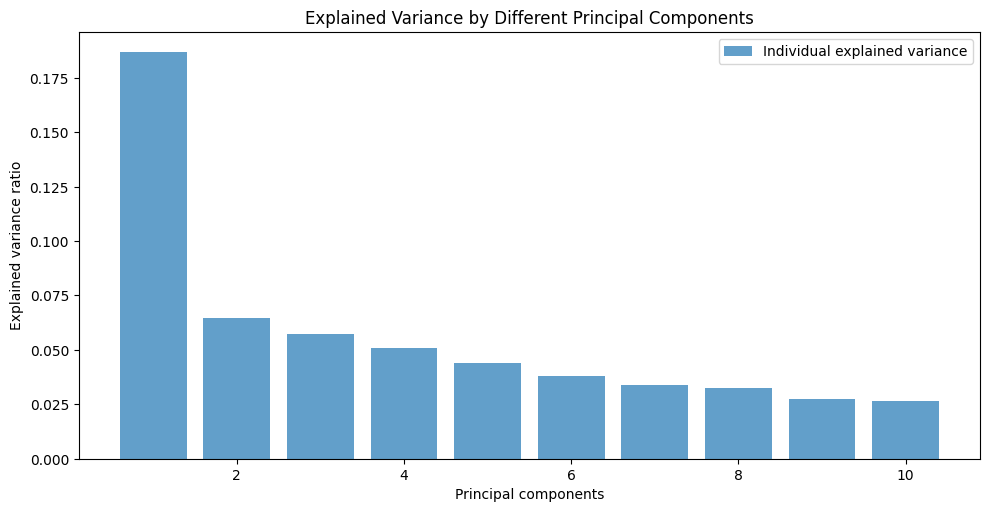

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49]
['Succession', 'Succession', 'N/A', 'Succession', 'Succession', 'Succession', 'Divorce', 'Succession', 'Succession', 'Succession', 'N/A', 'Divorce', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', '', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Divorce', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Divorce', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Succession', 'Divorce', 'Succession', 'Succession', 'Succession', 'Succession', '', 'N/A', 'Divorce', 'Succession']
['', 'Succession', 'N/A', 'Divorce']


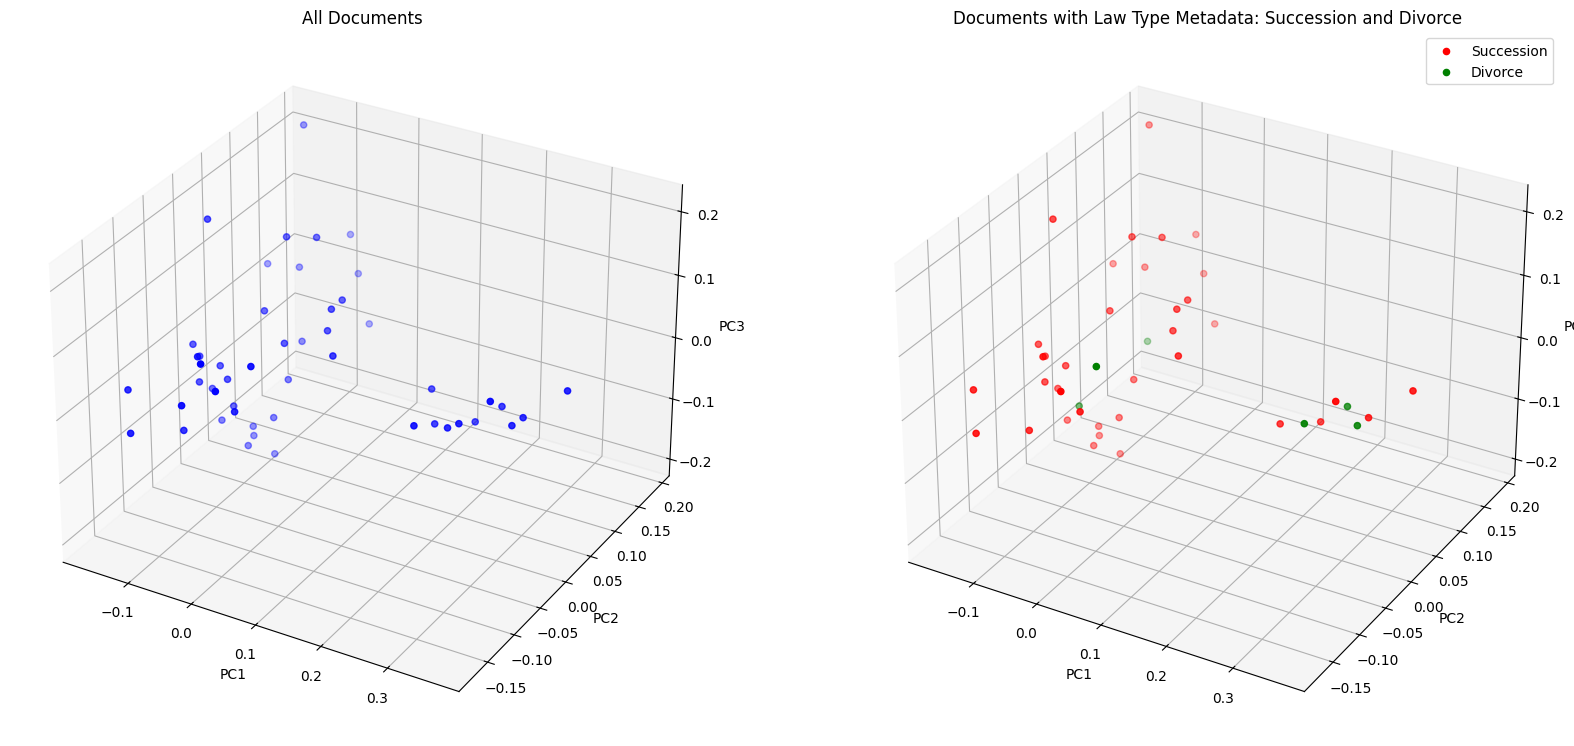

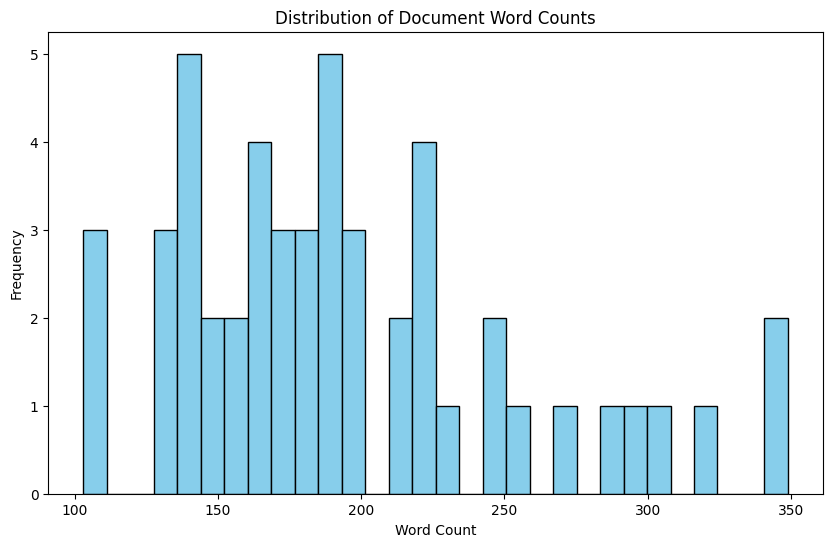

In [3]:

openai_api_key = os.getenv('OPENAI_API_KEY')  # Ensure your OpenAI API key is correctly set in your environment
explorer = Explorer(api_key=openai_api_key)

# Assuming `documents` is defined as a list of objects with 'page_content' and 'metadata'
cleaned_all_docs, metadata_list = explorer.preprocess_data(documents)
outliers_metadata_df, inliers_metadata_df , metadata_df = explorer.plot_embeddings_and_variance(cleaned_all_docs, metadata_list)
word_coount = explorer.count_words_distribution(cleaned_all_docs)



In [ ]:
pip install missingno

# RAG Class 

In [22]:
class RAG:
    def __init__(self, retriever, faiss_db):
        self.retriever = retriever
        self.faiss_db = faiss_db

    def retrieve_documents_generate_question_and_answer(self, question):
        # Define the generate_queries function
        #1st Template
        query_metadata = processor.extract_filters_from_query(question)
        # Check if the metadata dictionary is empty
        if not query_metadata or not query_metadata[0].metadata:
            return [], "Your question is too general or not inherent with the legal context. Please be more specific.", []
        print(query_metadata)

        final_metadata = {}
        # Check and update 'law_type' based on specified conditions
        succession_related_keys = ['succession_type', 'subject_of_succession', 'disputed_issues', 
                                    'relationship_between_parties', 'number_of_persons_involved', 
                                    'testamentary_clauses']
        divorce_related_keys = ['nature_of_separation', 'presence_of_children',
                                    'marital_regime', 'financial_support', 'duration_of_marriage']
        final_metadata = query_metadata[0].metadata
        if final_metadata.get('law_type') is None and any(final_metadata.get(k) is not None for k in succession_related_keys):
            final_metadata['law_type'] = 'Succession'
        if final_metadata.get('law_type') is None and any(final_metadata.get(k) is not None for k in divorce_related_keys):
                final_metadata['law_type'] = 'Divorce'
        print(final_metadata)
                
        pre_filtered_documents = self.faiss_db.similarity_search(question, filter={"law_type": final_metadata["law_type"]})


        # template = """You are an AI language model assistant. Your task is to generate 3 
        # different versions of the given user question 
        # In detail try to answer to these question :
        # In case of succession
        # 1.	Type of Succession: This section differentiates between testamentary succession (with a will) and legal succession (without a will).
        # 2.	Subject of Succession: Filters by type of inheritance assets involved (real estate, bank accounts, company shares, etc.).
        # 3.	Presence of Particular Testamentary Clauses: For example, legacies, trusts, or clauses excluding from inheritance (e.g. disinheritance clause).
        # 4.	Disputed Issues: This section identifies specific disputes, such as the validity of a will, the division of assets, or questions of legitimacy.
        # 5.	Relationship between Parties: Specifies the relationship between heir and de cuius (spouse, children, relatives, etc.).
        # 6.	Number of persons involved: Identifies the number of heirs and/or legatees. 
        # in case of divorce 
        # 1.	Nature of Separation: Voluntary or judicial, consensual, or contentious.
        # 2.	Presence of Children: Indicate whether children are involved and, if so, whether issues relating to custody, maintenance, and visitation rights are involved.
        # 3.	Marital Regime: Distinguish between community of property or separation of property and issues relating to the division of common property.
        # 4.	Financial Support: Filters relating to alimony or spousal maintenance.
        # 5.	Duration of Marriage: This may affect issues such as property division or maintenance.
        
        # Provide these alternative questions separated by newlines. Original question: {question}"""
        
        
        # 2nd Template MULTIQUERY
        template = """
        IMPORTANT: GENRATE QUESTIONS ONLY IN CASE THE ANSWER IS RELATED TO LEGAL ASPECTS OF SUCCESSION OR DIVORCE! IF NOT DO NOT GENERATE QUESTIONS
        IMPORTANT : IF USER QUESTION IS VALID GENERATE MAX 3 QUESTION, INDIPENDENTLY FROM THE ORIGINAL QUESTION , NO MORE THAN 3.
        
        You are an AI language model legal assistant. 
        Your task is to generate 3 different versions of the given user question to retrieve relevant documents from a vector 
        database.
        
        
        IMPORTANT : IF USER QUESTION IS VALID DO NOT PERFORM MORE THAN 3 QUESTION, INDIPENDENTLY FROM THE ORIGINAL QUESTION , NO MORE THAN 3.
        
        In detail try to answer to these question :
        1.	Type of Succession: This section differentiates between testamentary succession (with a will) and legal succession (without a will).
        2.	Subject of Succession: Filters by type of inheritance assets involved (real estate, bank accounts, company shares, etc.).
        3.	Presence of Particular Testamentary Clauses: For example, legacies, trusts, or clauses excluding from inheritance (e.g. disinheritance clause).
        4.	Disputed Issues: This section identifies specific disputes, such as the validity of a will, the division of assets, or questions of legitimacy.
        5.	Relationship between Parties: Specifies the relationship between heir and de cuius (spouse, children, relatives, etc.).
        6.	Number of persons involved: Identifies the number of heirs and/or legatees. in case of succession and  these : 
        1.	Nature of Separation: Voluntary or judicial, consensual, or contentious.
        2.	Presence of Children: Indicate whether children are involved and, if so, whether issues relating to custody, maintenance, and visitation rights are involved.
        3.	Marital Regime: Distinguish between community of property or separation of property and issues relating to the division of common property.
        4.	Financial Support: Filters relating to alimony or spousal maintenance.
        5.	Duration of Marriage: This may affect issues such as property division or maintenance.
        in case of divorce
        By generating multiple perspectives on the user question, your goal is to help
        the user overcome some of the limitations of the distance-based similarity search. 
        Provide these alternative questions separated by newlines.
        IMPORTANT : 
        Original question: {question}"""
        
        
        prompt_perspectives = ChatPromptTemplate.from_template(template)

        generate_queries = (
            prompt_perspectives 
            | ChatOpenAI(temperature=0) 
            | StrOutputParser() 
            | (lambda x: x.split("\n")))
        # Updated to store generated questions
        generated_questions = generate_queries.invoke({"question": question})
        gen_questions = "\n -".join(generated_questions)
        #reasoning_text = "\n\n".join([f"Question: {q}\nAnswer: (Placeholder answer for '{q}')" for q in generated_questions])
        # Define the get_unique_union function
        # Define a function to get a unique union of documents filtered by 'law_type'
        # Define a function to get a unique union of documents filtered by 'law_type'
        def get_unique_union(documents: list[list]):
            """Unique union of retrieved docs filtered by 'law_type'."""
            flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
            filtered_docs = [
                doc for doc in flattened_docs
                if 'law_type' in loads(doc).metadata and loads(doc).metadata['law_type'] == query_metadata['metadata']['law_type']
            ]
            unique_docs = list(set(filtered_docs))
            return [loads(doc) for doc in unique_docs]

        # Define the retrieval chain using pre-filtered documents
        retrieval_chain = generate_queries | (lambda _: pre_filtered_documents)



        # Retrieve documents
        documents = retrieval_chain.invoke({"question": gen_questions})
        
        

        # # Define the RAG chain: 1st LLM template
        # template = """ I am building a question answer application with legal documents as knowledge extension, Answer the following question based on this context (past sentences of a case similar to the question) 
        # EXPLICITATING THE most important CIVIL ARTICLES USED AND HOW THEY WERE USED (no more than 3) in simple words also for non legal people (not make an enumeration involve them in the generral speech), 
        # MOREOVER PROVIDE ALSO A SUMMARY OF a couple of SIMILAR CASES THAT YOU HAVE retrieved from YOUR KNOWLEDGE BASE give me a range of duration
        # and medium cost of the procedure (not specific cost but an estimate comparing other cases) ,avoiding to write down the anonymized subjects 
        # but trying to understand their roles in the perspective of user answer the proposed context is this, generate a valid answer trying to resolve the question,
        # and give me back also all the 3 questions in {question} for reaching this output (call them reasoning) GIVE ME IN THE FINAL RESPONSE THE subquestion in {question} and relative answer THAT U FORMULATED,
        # than printing a final overall evaluation (do not be repetitive between answer and question but alternate ), create a Similar cases section citing 
        # a couple of similar cases that you have found , their final resolution and articles used as examples. 
        # Finally print out a final evluation  Evaluation part generating your opinion based on them:
        # {context}

        # Question: {question}
        # """
        # 2nd LLM template
        
        #Define the RAG chain
        template = """ I am building a question answer application with legal documents as knowledge extension, Answer the following question based on this context (past sentences of a case similar to the question) 
        EXPLICITATING THE most important CIVIL ARTICLES USED AND HOW THEY WERE USED (no more than 3) in simple words also for non legal people (not make an enumeration involve them in the generral speech), 
        MOREOVER PROVIDE ALSO A SUMMARY OF a couple of SIMILAR CASES THAT YOU HAVE retrieved from YOUR KNOWLEDGE BASE give me a range of duration
        and medium cost of the procedure (not specific cost but an estimate comparing other cases) ,avoiding to write down the anonymized subjects 
        but trying to understand their roles in the perspective of user answer the proposed context is this, generate a valid answer trying to resolve the question,
        and give me back also all the 3 questions in {question} for reaching this output (call them reasoning) GIVE ME IN THE FINAL RESPONSE THE PRINT OF subquestion in Question: {question} and relative answer THAT U FORMULATED,
        than printing a final overall evaluation (do not be repetitive between answer and question but alternate ), create a Similar cases section citing 
        a couple of similar cases that you have found , their final resolution and articles used as examples. 
        Finally print out a final evluation  Evaluation part generating your opinion based on them:
        {context}

        Question: {question}
        """
        
        


        prompt = ChatPromptTemplate.from_template(template)

        llm = ChatOpenAI(temperature=0)

        final_rag_chain = (
            {"context": retrieval_chain, 
            "question": itemgetter("question")}
            | prompt
            | llm
            | StrOutputParser()
        )

        # Generate the answer
        generated_answer = final_rag_chain.invoke({"question": question})
        
        # POSSIBLE SUMMARIZATION ?
        
        # prompt_legal_reasons = """Write a long as you  summary of the following text, take in account that this is legal text explaining the progress of a cause, try to summarize 
        # each step of it in a proper way using as reference the Question:
        # "{text}"
        # SUMMARY:"""
        # summarized_documents = []
        # llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
        # llm_chain_legal_reasons = LLMChain(llm=llm, prompt=PromptTemplate.from_template(prompt_legal_reasons))
        # for doc in documents: 
        #         summary = llm_chain_legal_reasons.run({"text": doc.page_content})
        #         # Create a new Document instance with the summary as the page_content
        #         summarized_doc = LangChainDocument(page_content=summary)
        #         summarized_doc.append(summarized_documents)
        
        # print(summarized_documents)
        
        # final_rag_chain_2 = (
        #     {"context": summarized_documents, 
        #     "question": itemgetter("question")}
        #     | prompt
        #     | llm
        #     | StrOutputParser()
        # )    
        # # Generate the answer
        # generated_answer = final_rag_chain_2.invoke({"question": question})

        return documents, generated_answer , generated_questions , gen_questions , question , final_metadata

In [179]:
generated_questions

"1. What type of succession is involved in John's case, considering the disputes over the validity of certain clauses in his will?\n2. How do the particular testamentary clauses, such as trusts and exclusions from inheritance, impact the distribution of John's estate among his family members?\n3. With John's spouse, children, and relatives involved in the succession process, how might the complex relationships between the parties affect the division of assets and the number of heirs and legatees?\n\n1. What are the disputed issues surrounding John's will, especially concerning the validity of certain clauses like trusts and exclusions from inheritance?\n2. How does the relationship between John's family members, including his spouse, children, and relatives, influence the distribution of assets in the succession process?\n3. How does the presence of particular testamentary clauses in John's will complicate the legal implications of the contested clauses and impact the number of heirs a

# TENTATIVI

**1ST TEMPLATE**

In [24]:
# RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "John, a wealthy individual, recently passed away, leaving behind a significant estate comprising real estate properties, bank accounts, and company shares. His testamentary wishes were outlined in a will; however, disputes have arisen regarding the validity of certain clauses within the will, notably those related to trusts and exclusions from inheritance. John's family members, including his spouse, children, and relatives, are involved in the succession process, adding complexity due to differing opinions on the division of assets. In light of these circumstances, what are the legal implications of the contested clauses in John's will, and how might the complex relationships between the parties impact the distribution of assets among the multiple heirs and legatees?"
documents, generated_answer , generated_questions, gen_questions , question , metadata = rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", documents)
print("Generated Answer:", generated_answer)

[Document(page_content="John, a wealthy individual, recently passed away, leaving behind a significant estate comprising real estate properties, bank accounts, and company shares. His testamentary wishes were outlined in a will; however, disputes have arisen regarding the validity of certain clauses within the will, notably those related to trusts and exclusions from inheritance. John's family members, including his spouse, children, and relatives, are involved in the succession process, adding complexity due to differing opinions on the division of assets. In light of these circumstances, what are the legal implications of the contested clauses in John's will, and how might the complex relationships between the parties impact the distribution of assets among the multiple heirs and legatees?", metadata={'subject_of_succession': 'real estate, bank accounts, company shares', 'testamentary_clauses': ['trusts', 'exclusions from inheritance'], 'disputed_issues': 'validity of will', 'relatio

In [ ]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "tell me HOW TO MAKE MONEy"
documents, generated_answer , generated_questions = rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", documents)
print("Generated Answer:", generated_answer)

Retrieved Documents: []
Generated Answer: Your question is too general or not inherent with the legal context. Please be more specific.


**2ND TEMPLATE**

## Divorce

**1**

In [25]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "What is the process for filing for divorce, and how long does it typically take?"
documents_D1, generated_answer_D1 , generated_questions_D1, gen_questions_D1 , question_D1 , query_metadata_D1= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_D1) ,documents_D1)
print("Generated Answer:", generated_answer_D1)
print("Questions : " ,generated_questions_D1)
print("Metadata : " ,query_metadata_D1)

[Document(page_content='What is the process for filing for divorce, and how long does it typically take?', metadata={'law_type': 'Divorce', 'duration': 'typically take'})]
{'law_type': 'Divorce', 'duration': 'typically take'}
Retrieved Documents: 4 [Document(page_content='This legal text provides a summary of the progress of a specific case without mentioning the names of the parties involved. The case began with the filing of a complaint by one party against another, followed by the defendant filing an answer. Both parties then engaged in the discovery process, exchanging documents and conducting depositions. If a settlement was not reached, the case proceeded to trial, where both parties presented their arguments and evidence. After the trial, the court issued a judgment determining the outcome of the case. Either party had the option to file an appeal, which would be reviewed by a higher court. The text does not provide information on the outcome of the appeal or any further steps i

**2**

In [26]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "My spouse and I are considering a divorce, but we own a business together. How will our business assets be divided, and what are the implications for our business operations?"
documents_D2, generated_answer_D2 , generated_questions_D2, gen_questions_D2 , question_D2 , query_metadata_D2= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_D2) , documents_D2)
print("Generated Answer:", generated_answer_D2)
print("Questions : " ,generated_questions_D2)
print("Metadata : " ,query_metadata_D2)

[Document(page_content='My spouse and I are considering a divorce, but we own a business together. How will our business assets be divided, and what are the implications for our business operations?', metadata={'subject_of_succession': 'business assets', 'law_type': 'Divorce', 'disputed_issues': 'division of assets'})]
{'subject_of_succession': 'business assets', 'law_type': 'Divorce', 'disputed_issues': 'division of assets'}
Retrieved Documents: 2 [Document(page_content='This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-ap

**3**

In [27]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "My spouse and I are considering a divorce, but we own a business together we have a child how is determined the child retention?"
documents_D3, generated_answer_D3 , generated_questions_D3, gen_questions_D3 , question_D3 , query_metadata_D3= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_D3) , documents_D3)
print("Generated Answer:", generated_answer_D3)
print("Questions : " ,generated_questions_D3)
print("Metadata : " ,query_metadata_D3)

[Document(page_content='My spouse and I are considering a divorce, but we own a business together we have a child how is determined the child retention?', metadata={'law_type': 'Divorce', 'presence_of_children': True})]
{'law_type': 'Divorce', 'presence_of_children': True}
Retrieved Documents: 0 []
Generated Answer: In cases similar to yours, the most important civil articles used typically revolve around child custody and support. These articles are used to determine the best interests of the child and ensure their well-being is prioritized during the divorce proceedings.

One similar case involved a couple who owned a business together and had a child. The duration of the legal procedure in this case ranged from several months to a year, depending on the complexity of the situation. The medium cost of the procedure varied, but it was estimated to be in the range of several thousand dollars to tens of thousands of dollars.

In determining child custody, the court considers factors suc

**4**

In [28]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "I am currently unemployed and going to divorcing, what are the expenses of divorce, who pays ?"
documents_D4, generated_answer_D4 , generated_questions_D4, gen_questions_D4 , question_D4 , query_metadata_D4= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_D4) , documents_D4)
print("Generated Answer:", generated_answer_D4)
print("Questions : " ,generated_questions_D4)
print("Metadata : " ,query_metadata_D4)

[Document(page_content='I am currently unemployed and going to divorcing, what are the expenses of divorce, who pays ?', metadata={'law_type': 'Divorce', 'cost': 'expenses of divorce', 'subject_of_succession': 'properties', 'financial_support': 'expenses of divorce'})]
{'law_type': 'Divorce', 'cost': 'expenses of divorce', 'subject_of_succession': 'properties', 'financial_support': 'expenses of divorce'}
Retrieved Documents: 2 [Document(page_content='This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-appointed technical cons

In [29]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "As a stay-at-home parent during our marriage,Now that we're going to divorcing, am I entitled to spousal support to help me?"
documents_D5, generated_answer_D5 , generated_questions_D5, gen_questions_D5 , question_D5 , query_metadata_D5= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_D5) , documents_D5)
print("Generated Answer:", generated_answer_D5)
print("Questions : " ,generated_questions_D5)
print("Metadata : " ,query_metadata_D5)

[Document(page_content="As a stay-at-home parent during our marriage,Now that we're going to divorcing, am I entitled to spousal support to help me?", metadata={'nature_of_separation': 'Judicial', 'financial_support': 'spousal support'})]
{'nature_of_separation': 'Judicial', 'financial_support': 'spousal support', 'law_type': 'Divorce'}
Retrieved Documents: 2 [Document(page_content='This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-appointed technical consultant provided estimates and clarifications regarding the assets inv

### Succession

**1**

In [30]:
# RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "John, a wealthy individual, recently passed away, leaving behind a significant estate comprising real estate properties, bank accounts, and company shares. His testamentary wishes were outlined in a will; however, disputes have arisen regarding the validity of certain clauses within the will, notably those related to trusts and exclusions from inheritance. John's family members, including his spouse, children, and relatives, are involved in the succession process, adding complexity due to differing opinions on the division of assets. In light of these circumstances, what are the legal implications of the contested clauses in John's will, and how might the complex relationships between the parties impact the distribution of assets among the multiple heirs and legatees?"
documents_S1, generated_answer_S1 , generated_questions_S1, gen_questions_S1 , question_S1 , query_metadata_S1= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_S1) , documents_S1)
print("Generated Answer:", generated_answer_S1)
print("Questions : " ,generated_questions_S1)
print("Metadata : " ,query_metadata_S1)

[Document(page_content="John, a wealthy individual, recently passed away, leaving behind a significant estate comprising real estate properties, bank accounts, and company shares. His testamentary wishes were outlined in a will; however, disputes have arisen regarding the validity of certain clauses within the will, notably those related to trusts and exclusions from inheritance. John's family members, including his spouse, children, and relatives, are involved in the succession process, adding complexity due to differing opinions on the division of assets. In light of these circumstances, what are the legal implications of the contested clauses in John's will, and how might the complex relationships between the parties impact the distribution of assets among the multiple heirs and legatees?", metadata={'subject_of_succession': 'real estate, bank accounts, company shares', 'testamentary_clauses': ['trusts', 'exclusions from inheritance'], 'disputed_issues': 'validity of will', 'relatio

**2**

In [18]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import OpenAI

In [31]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "i'm divorcing from my wife and i have a children what is procedure of succession and relative inheritance in this case for my child , my ex-wife will benefit?"
documents_S2, generated_answer_S2 , generated_questions_S2, gen_questions_S2 , question_S2 , query_metadata_S2= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_S2) , documents_S2)
print("Generated Answer:", generated_answer_S2)
print("Questions : " ,generated_questions_S2)
print("Metadata : " ,query_metadata_S2)

[Document(page_content="i'm divorcing from my wife and i have a children what is procedure of succession and relative inheritance in this case for my child , my ex-wife will benefit?", metadata={'law_type': 'Divorce', 'presence_of_children': True, 'subject_of_succession': 'inheritance', 'relationship_between_parties': 'spouses', 'number_of_persons_involved': 2})]
{'law_type': 'Divorce', 'presence_of_children': True, 'subject_of_succession': 'inheritance', 'relationship_between_parties': 'spouses', 'number_of_persons_involved': 2}
Retrieved Documents: 0 []
Generated Answer: In a similar case, the most important civil articles used were those related to child custody, division of assets, and spousal support. These articles were used to determine the best interests of the child, the fair distribution of property, and financial support for the ex-spouse.

In a couple of similar cases retrieved from the knowledge base, the duration of the procedure ranged from 6 months to 2 years, with a me

In [198]:
gen_questions

'1. What is the nature of your separation from your wife - voluntary or judicial, consensual, or contentious? Are there any specific issues related to the divorce process that you are concerned about?\n - 2. Do you have children with your wife, and if so, are there any custody, maintenance, or visitation rights issues that need to be addressed during the divorce proceedings?\n - 3. What is the marital regime that you and your wife have - community of property or separation of property? Are there any concerns regarding the division of common property?\n - 4. Are you seeking financial support in the form of alimony or spousal maintenance as part of the divorce settlement?\n - 5. How long have you been married to your wife, and how might the duration of your marriage impact issues such as property division or maintenance payments?\n - \n - 1. Could you provide more details about the nature of your divorce from your wife - whether it is voluntary or judicial, consensual, or contentious? Ar

**3**

In [32]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "What happens if someone dies without a will and has real estate in different states?"
documents_S3, generated_answer_S3 , generated_questions_S3, gen_questions_S3 , question_S3 , query_metadata_S3= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_S3) , documents_S3)
print("Generated Answer:", generated_answer_S3)
print("Questions : " ,generated_questions_S3)
print("Metadata : " ,query_metadata_S3)

[Document(page_content='What happens if someone dies without a will and has real estate in different states?', metadata={'succession_type': 'legal', 'subject_of_succession': 'real estate'})]
{'succession_type': 'legal', 'subject_of_succession': 'real estate', 'law_type': 'Succession'}
Retrieved Documents: 4 [Document(page_content='In this legal case, a hereditary communion between the parties involved has been dissolved by the court. The assets of the deceased, M.F., will be divided among the heirs. M.V. will receive exclusive ownership of three apartments, M.L. will receive exclusive ownership of an apartment and a garage, and V.M. will receive exclusive ownership of a plot of land. However, V.M. will also be obligated to pay adjustments to the plaintiffs. The court referred to various articles of the Civil Code to determine the division of assets and collation of donations. The plaintiffs accused V.M. of unlawfully withdrawing money from bank accounts for personal use, which was conf

**4**

In [33]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "Can a will that includes a disinheritance clause be contested by a disinherited child?"
documents_S4, generated_answer_S4 , generated_questions_S4, gen_questions_S4 , question_S4 , query_metadata_S4= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_S4) , documents_S4)
print("Generated Answer:", generated_answer_S4)
print("Questions : " ,generated_questions_S4)
print("Metadata : " ,query_metadata_S4)

[Document(page_content='Can a will that includes a disinheritance clause be contested by a disinherited child?', metadata={'testamentary_clauses': ['disinheritance']})]
{'testamentary_clauses': ['disinheritance'], 'law_type': 'Succession'}
Retrieved Documents: 4 [Document(page_content="This legal text summarizes the progress of a case involving the succession of a deceased person. The court declared the succession open and accepted the plaintiff's claim for compensation. The plaintiffs were awarded monetary adjustments, including interest, in favor of certain parties. The defendants' counterclaims were rejected. The court also ordered the division of the inheritance and appointed an expert witness to create a division plan. The defendants were ordered to pay the costs of the suit. The court considered various legal principles and rules of civil procedure in reaching its decision. The case involved the deceased's children and their rights to the inheritance. The court also addressed iss

**5**

In [34]:
# # RAG
# retriever = Retriever("C:/Users/ALBER/OneDrive/Desktop/Legal-Bot/Processed_JSONs")
retriever = faiss_db  # Assuming faiss_db is defined
rag = RAG(retriever, faiss_db)
question = "If the deceased left a trust for his grandchildren, how does this affect the distribution of his other assets?"
documents_S5, generated_answer_S5 , generated_questions_S5, gen_questions_S5 , question_S5 , query_metadata_S5= rag.retrieve_documents_generate_question_and_answer(question)
print("Retrieved Documents:", len(documents_S5) , documents_S5)
print("Generated Answer:", generated_answer_S5)
print("Questions : " ,generated_questions_S5)
print("Metadata : " ,query_metadata_S5)

[Document(page_content='If the deceased left a trust for his grandchildren, how does this affect the distribution of his other assets?', metadata={'testamentary_clauses': ['trust'], 'disputed_issues': 'division of assets'})]
{'testamentary_clauses': ['trust'], 'disputed_issues': 'division of assets', 'law_type': 'Succession'}
Retrieved Documents: 4 [Document(page_content='In this legal case, a hereditary communion between the parties involved has been dissolved by the court. The assets of the deceased, M.F., will be divided among the heirs. M.V. will receive exclusive ownership of three apartments, M.L. will receive exclusive ownership of an apartment and a garage, and V.M. will receive exclusive ownership of a plot of land. However, V.M. will also be obligated to pay adjustments to the plaintiffs. The court referred to various articles of the Civil Code to determine the division of assets and collation of donations. The plaintiffs accused V.M. of unlawfully withdrawing money from bank

# EVALUATION WITH RAGAS

In [35]:
question_S5

'If the deceased left a trust for his grandchildren, how does this affect the distribution of his other assets?'

In [36]:
gt1 = "Answer:Subquestion in Question: What is the process for filing for divorce, and how long does it typically take?Answer:To file for divorce, one typically needs to initiate proceedings by submitting a petition to the court, outlining the grounds for divorce and other relevant details. The process may involve negotiations between the parties regarding asset division, child custody, and support arrangements. Key civil articles often used include those governing grounds for divorce, property division, and child custody.Reasoning for Question: What are the civil articles involved in the divorce process? Answer:Subquestion in Question: What are the civil articles involved in the divorce process?Answer:The civil articles commonly involved in the divorce process include those concerning grounds for divorce, property division, and child custody. These articles outline the legal framework for resolving disputes and reaching agreements between the parties involved.Reasoning for Question: Can you provide a summary of similar divorce cases, including duration and cost?Answer:Subquestion in Question: Can you provide a summary of similar divorce cases, including duration and cost?Answer:Similar divorce cases have varied in duration, typically ranging from several months to a few years, depending on the complexity of the issues involved and the level of cooperation between the parties. The cost of divorce proceedings can also vary widely, with estimates ranging from moderate to high, considering factors such as legal fees, court expenses, and any additional professional services required.Similar Cases:Case 1: In a divorce case similar to yours, the proceedings lasted approximately 18 months, with moderate costs involved. The key civil articles utilized included those governing property division and spousal support.Case 2: Another divorce case saw a relatively shorter duration of around 8 months, with higher costs due to contentious disputes over child custody and support. Articles related to child custody and visitation rights were prominently invoked.Final Evaluation:Based on the provided information, navigating the divorce process can vary significantly in duration and cost, influenced by factors such as the complexity of issues and the level of cooperation between the parties. Understanding the relevant civil articles and seeking legal guidance can help streamline the process and ensure a fair resolution for all parties involved."

gt2 = """Answer:
Subquestion in Question: My spouse and I are considering a divorce, but we own a business together. How will our business assets be divided, and what are the implications for our business operations?
Answer:
In the case of divorcing spouses who jointly own a business, the division of business assets can be complex. Typically, civil articles related to property division, business valuation, and partnership agreements are key in determining how business assets will be divided. These articles provide the legal framework for assessing the value of the business, determining each spouse's ownership stake, and facilitating negotiations for an equitable distribution of assets.

Reasoning for Question: What are the implications for business operations during a divorce involving co-ownership of a business?
Answer:
Subquestion in Question: What are the implications for business operations during a divorce involving co-ownership of a business?
Answer:
During a divorce involving co-ownership of a business, there are several implications for business operations. These may include disruptions due to legal proceedings, changes in ownership structure, and potential conflicts between the divorcing spouses affecting decision-making processes. Key civil articles related to business operations may include those governing corporate governance, management rights, and dispute resolution mechanisms.

Reasoning for Question: Can you provide a summary of similar divorce cases involving co-owned businesses, including duration and cost?
Answer:
Subquestion in Question: Can you provide a summary of similar divorce cases involving co-owned businesses, including duration and cost?
Answer:
Similar divorce cases involving co-owned businesses have varied in duration and cost, depending on factors such as the size of the business, the complexity of ownership arrangements, and the level of cooperation between the divorcing spouses. Duration estimates range from several months to a few years, with costs spanning from moderate to high due to legal fees, business valuation expenses, and potential settlement negotiations.

Similar Cases:
Case 1: In a divorce involving co-owned businesses, the proceedings lasted approximately 24 months, with significant costs incurred for business valuation and asset division. Civil articles pertaining to partnership agreements and business valuation methodologies were instrumental in reaching a settlement.
Case 2: Another similar case saw a relatively shorter duration of around 12 months, with moderate costs associated with legal fees and business appraisal services. Articles related to corporate governance and ownership rights were central to resolving disputes and facilitating the division of business assets.
Final Evaluation:
Based on the provided information, divorces involving co-owned businesses present unique challenges, requiring careful consideration of relevant civil articles and business implications. Navigating such cases may involve significant time and expense, underscoring the importance of seeking legal guidance and pursuing amicable resolutions to mitigate disruptions to business operations."""


gt3 = """Subquestion in Question: My spouse and I are considering a divorce, but we own a business together. We have a child. How is the child custody determined?
Answer:
In divorce cases involving children, the determination of child custody is typically guided by civil articles related to parental rights, the best interests of the child, and custody arrangements. Courts aim to ensure the well-being and welfare of the child, considering factors such as the child's age, health, relationship with each parent, and any special needs or circumstances.

Reasoning for Question: What civil articles are involved in determining child custody during a divorce?
Answer:
Subquestion in Question: What civil articles are involved in determining child custody during a divorce?
Answer:
Civil articles commonly involved in determining child custody during a divorce include those governing parental rights, the best interests of the child, and custody arrangements. These articles provide the legal framework for courts to assess parental fitness, consider the child's needs, and establish custody and visitation schedules.

Reasoning for Question: Can you provide a summary of similar divorce cases involving child custody disputes, including duration and cost?
Answer:
Subquestion in Question: Can you provide a summary of similar divorce cases involving child custody disputes, including duration and cost?
Answer:
Similar divorce cases involving child custody disputes have varied in duration and cost, depending on factors such as the complexity of custody arrangements, the level of cooperation between the parents, and any contested issues. Duration estimates range from several months to a few years, with costs spanning from moderate to high due to legal fees, custody evaluations, and potential mediation or trial proceedings.

Similar Cases:
Case 1: In a divorce involving child custody disputes, the proceedings lasted approximately 18 months, with moderate costs incurred for custody evaluations and legal representation. Civil articles pertaining to parental rights and the best interests of the child were central to the court's decision-making process.
Case 2: Another similar case saw a relatively shorter duration of around 10 months, with lower costs associated with amicable negotiations and mediation sessions. Articles related to custody arrangements and visitation schedules were crucial in reaching a mutually agreeable custody agreement.
Final Evaluation:
Based on the provided information, determining child custody during a divorce involves careful consideration of relevant civil articles and the unique circumstances of each case. The well-being of the child is paramount, and courts strive to establish custody arrangements that serve the child's best interests while promoting parental involvement and cooperation. Seeking legal guidance and exploring alternative dispute resolution methods can help facilitate a smoother and more amicable resolution to child custody disputes."""


gt4 = """Answer:
Subquestion in Question: I am currently unemployed and going through a divorce. What are the expenses of divorce, and who pays for them?
Answer:
The expenses of divorce can vary depending on factors such as legal fees, court costs, mediation or counseling fees, and any additional professional services required. Typically, each spouse is responsible for covering their own legal expenses, although in some cases, the court may order one spouse to contribute to the other's legal fees, especially if there is a significant disparity in income or financial resources.

Reasoning for Question: What are the typical expenses associated with divorce proceedings?
Answer:
Subquestion in Question: What are the typical expenses associated with divorce proceedings?
Answer:
Typical expenses associated with divorce proceedings include legal fees for attorneys or mediators, court filing fees, costs related to obtaining financial or property valuations, fees for custody evaluations or parenting classes, and expenses for any necessary expert witnesses or consultants. These expenses can vary depending on the complexity of the case and the level of contention between the spouses.

Reasoning for Question: Who is responsible for covering the expenses of divorce?
Answer:
Subquestion in Question: Who is responsible for covering the expenses of divorce?
Answer:
In general, each spouse is responsible for covering their own expenses related to divorce, including legal fees and other costs associated with the proceedings. However, the court may consider factors such as income disparity, financial resources, and the conduct of the parties when determining whether one spouse should contribute to the other's expenses. This determination is made on a case-by-case basis, taking into account the equitable distribution of financial responsibilities.

Similar Cases:
Case 1: In a divorce case involving an unemployed spouse, the court ordered the employed spouse to contribute to the unemployed spouse's legal fees and living expenses during the divorce proceedings, considering the financial hardship faced by the unemployed spouse.
Case 2: Another similar case saw both spouses agreeing to share the costs of divorce equally, including legal fees and other related expenses, as part of a negotiated settlement. This arrangement helped avoid additional conflict and litigation over financial matters.
Final Evaluation:
Based on the provided information, the expenses of divorce can be significant and may include various fees and costs associated with legal representation, court proceedings, and additional services. While each spouse is generally responsible for their own expenses, the court may intervene to ensure fairness and equity, particularly in cases where one spouse faces financial hardship or disadvantage. Seeking legal advice and exploring options for cost-effective resolution can help minimize the financial burden of divorce and facilitate a smoother transition for both parties."""


gt5 = """Answer:
Subquestion in Question: "As a stay-at-home parent during our marriage, Now that we're going to divorcing, am I entitled to spousal support to help me?"
Answer:
In divorce cases where one spouse has been the primary caregiver and stayed home to care for children or manage household responsibilities, they may be entitled to spousal support, also known as alimony. The determination of spousal support eligibility and amount is typically guided by civil articles related to marital property division, financial needs, earning capacity, and the standard of living established during the marriage.

Reasoning for Question: What civil articles are involved in determining spousal support eligibility during a divorce?
Answer:
Subquestion in Question: What civil articles are involved in determining spousal support eligibility during a divorce?
Answer:
Civil articles commonly involved in determining spousal support eligibility during a divorce include those governing marital property division, financial needs, earning capacity, and the standard of living established during the marriage. These articles provide the legal framework for courts to assess the financial circumstances of each spouse and determine whether spousal support is appropriate and, if so, the amount and duration of support.

Reasoning for Question: Can you provide a summary of similar divorce cases involving spousal support claims, including duration and outcome?
Answer:
Subquestion in Question: Can you provide a summary of similar divorce cases involving spousal support claims, including duration and outcome?
Answer:
Similar divorce cases involving spousal support claims have varied in duration and outcome, depending on factors such as the length of the marriage, the financial circumstances of the parties, and any contested issues. Duration estimates range from several months to a few years, with outcomes ranging from spousal support awards to negotiated settlements or court rulings denying spousal support. The resolution of spousal support claims often depends on the specific facts and circumstances of each case, as well as the applicable civil articles and legal arguments presented by the parties.

Similar Cases:
Case 1: In a divorce case where one spouse was a stay-at-home parent, the court awarded spousal support for a duration of five years, considering the length of the marriage and the financial needs of the supported spouse. Civil articles related to marital property division and financial needs were instrumental in determining the spousal support award.
Case 2: Another similar case saw the spouses reaching a negotiated settlement for spousal support, with the supported spouse receiving monthly payments for a period of three years. The settlement took into account the supported spouse's contributions to the marriage and their need for financial assistance during the transition to single life.
Final Evaluation:
Based on the provided information, spousal support entitlement during a divorce is determined by various factors, including the length of the marriage, financial needs, earning capacity, and the standard of living established during the marriage. Seeking legal advice and advocating for one's rights can help ensure fair treatment and financial support for spouses, particularly those who have sacrificed their careers or opportunities to support the family during the marriage.






"""

gt6="""Answer:
Subquestion in Question: What are the legal implications of the contested clauses in John's will?
Answer:
The contested clauses in John's will, particularly those related to trusts and exclusions from inheritance, have significant legal implications for the distribution of his estate. Civil articles governing wills, trusts, and inheritance laws will be instrumental in determining the validity and enforceability of these clauses. Any disputes regarding the interpretation or execution of these clauses may lead to litigation or alternative dispute resolution methods, potentially prolonging the succession process and adding complexity to the distribution of assets.

Reasoning for Question: How might the complex relationships between the parties impact the distribution of assets among the multiple heirs and legatees?
Answer:
The complex relationships between John's family members, including his spouse, children, and relatives, can impact the distribution of assets in several ways. Civil articles related to family law, inheritance rights, and fiduciary duties may come into play, as the parties navigate their respective claims and interests in the estate. Conflicting opinions and disputes among the heirs and legatees could result in negotiations, settlements, or litigation to resolve issues such as contested clauses, unequal distributions, or allegations of undue influence or coercion.

Reasoning for Question: What civil articles are involved in the succession process and resolution of disputes over John's estate?
Answer:
Civil articles involved in the succession process and resolution of disputes over John's estate may include those governing wills and testaments, trusts, inheritance laws, family relationships, and fiduciary obligations. These articles provide the legal framework for interpreting John's testamentary wishes, determining the validity of contested clauses, and ensuring equitable distribution of assets among the heirs and legatees.

Similar Cases:
Case 1: In a similar estate dispute involving contested clauses in a will, the succession process lasted approximately three years, with moderate costs incurred for legal fees, court proceedings, and mediation sessions. Civil articles pertaining to testamentary capacity and undue influence were central to resolving the disputes and reaching a settlement among the parties.
Case 2: Another comparable case saw a relatively shorter succession process of around 18 months, with higher costs due to complex family dynamics and contested trust provisions. Articles related to trusts and fiduciary duties were crucial in determining the validity of the contested clauses and facilitating the distribution of assets among the heirs and beneficiaries.
Final Evaluation:
Based on the provided information, the legal implications of contested clauses in John's will and the complex relationships between the parties can significantly impact the succession process and distribution of assets. Navigating such disputes may require careful consideration of relevant civil articles, strategic negotiation, and possibly court intervention to ensure a fair and equitable resolution for all parties involved. Seeking legal guidance and exploring alternative dispute resolution methods can help mitigate conflicts and streamline the succession process, ultimately preserving family relationships and protecting the integrity of John's testamentary wishes.
"""

gt7= """Subquestion in Question: What is the procedure of succession and relative inheritance in this case for my child, considering that my ex-wife will benefit?
Answer:
In the event of divorce and subsequent succession, the procedure of inheritance for your child will depend on various factors such as the presence of a will, applicable inheritance laws, and any court orders or agreements related to child custody and support. Civil articles governing family law, inheritance, and parental rights will be instrumental in determining the legal framework for succession and inheritance rights for your child, particularly in cases where your ex-wife may benefit from the estate.

Reasoning for Question: What civil articles are involved in determining the procedure of succession and relative inheritance for your child in this case?
Answer:
Civil articles involved in determining the procedure of succession and relative inheritance for your child in this case include those governing family law, parental rights, child support obligations, and inheritance laws. These articles provide the legal framework for addressing issues such as child custody, visitation rights, support payments, and inheritance rights, ensuring that your child's interests are protected and their rights to the estate are upheld.

Reasoning for Question: How might the benefits received by your ex-wife impact the inheritance rights of your child in the succession process?
Answer:
The benefits received by your ex-wife in the succession process may impact the inheritance rights of your child, particularly if your ex-wife is entitled to a share of the estate as a surviving spouse or through other legal provisions. Civil articles related to marital property rights, wills, trusts, and intestacy laws may come into play in determining the distribution of assets and the allocation of inheritance shares among the heirs, including your child. It's essential to seek legal advice to ensure that your child's inheritance rights are protected and enforced appropriately in light of your divorce and the benefits received by your ex-wife.

Similar Cases:
Case 1: In a similar scenario involving divorce and succession, the succession process lasted approximately 18 months, with moderate costs incurred for legal fees, court proceedings, and estate administration services. Civil articles pertaining to family law and inheritance rights were central to resolving issues related to child inheritance and spousal benefits from the estate.
Case 2: Another comparable case saw a relatively longer succession process of around two years, with higher costs due to contested provisions in the divorce settlement regarding asset division and inheritance arrangements. Articles related to wills, trusts, and estate litigation were crucial in determining the final distribution of assets and protecting the inheritance rights of the children involved.
Final Evaluation:
Based on the provided information, the procedure of succession and relative inheritance for your child in the context of divorce and benefits received by your ex-wife can be complex and require careful consideration of applicable civil articles and legal provisions. Seeking legal guidance and advocating for your child's inheritance rights can help ensure a fair and equitable distribution of assets and uphold your child's interests amidst the challenges of divorce and succession."""


gt8 = """Subquestion in Question: What happens if someone dies without a will and has real estate in different states?
Answer:
When someone dies without a will, they are said to have died "intestate." In such cases, the distribution of their assets, including real estate, is governed by the intestacy laws of each state where the real estate is located. Typically, the intestacy laws prioritize distribution to the deceased person's closest living relatives, such as spouses, children, parents, or siblings, in a predetermined order of succession outlined by the state's laws.

Reasoning for Question: What civil articles are involved in the distribution of assets when someone dies intestate with real estate in different states?
Answer:
The distribution of assets when someone dies intestate with real estate in different states is governed by civil articles related to intestacy laws, property rights, and probate procedures in each respective state. These articles provide the legal framework for determining the heirs of the deceased person's estate and the process for administering the estate, including the sale or transfer of real estate located in multiple states.

Reasoning for Question: Can you provide a summary of similar cases involving intestacy and real estate in multiple states, including duration and outcome?
Answer:
Similar cases involving intestacy and real estate in multiple states have varied in duration and outcome, depending on factors such as the complexity of the estate, the number of heirs, and any disputes among the parties involved. Duration estimates range from several months to a few years, with costs varying depending on legal fees, court expenses, and estate administration costs. The outcome typically involves the distribution of the deceased person's assets according to the intestacy laws of each state, ensuring that the rightful heirs receive their respective shares of the estate.

Similar Cases:
Case 1: In a case involving intestacy and real estate in multiple states, the estate administration process lasted approximately two years, with moderate costs incurred for legal fees, probate proceedings, and property transfer expenses. The outcome resulted in the distribution of the deceased person's assets among their closest living relatives according to the intestacy laws of each state.
Case 2: Another comparable case saw a relatively shorter estate administration process of around 12 months, with higher costs due to contested claims and disputes among the heirs regarding the distribution of real estate located in different states. Despite the challenges, the outcome resulted in a court-approved distribution plan that upheld the intestacy laws and ensured fair treatment of the deceased person's heirs.
Final Evaluation:
Based on the provided information, the distribution of assets when someone dies intestate with real estate in different states is governed by intestacy laws and probate procedures in each respective state. Navigating such cases may involve legal complexities and require careful consideration of applicable civil articles and estate administration procedures to ensure that the deceased person's assets are distributed in accordance with the law and the rightful heirs receive their entitled shares of the estate."""

gt9="""Subquestion in Question: Can a will that includes a disinheritance clause be contested by a disinherited child?
Answer:
Yes, a will that includes a disinheritance clause can be contested by a disinherited child under certain circumstances. Civil articles governing wills, testamentary capacity, and undue influence may come into play in contesting the validity of the disinheritance clause. The disinherited child may contest the clause on grounds such as lack of testamentary capacity of the deceased, undue influence exerted by other beneficiaries, or failure to comply with formalities required for a valid will.

Reasoning for Question: What civil articles are involved in contesting a will with a disinheritance clause by a disinherited child?
Answer:
The civil articles involved in contesting a will with a disinheritance clause by a disinherited child may include those related to testamentary capacity, undue influence, and formal requirements for a valid will. These articles provide the legal framework for challenging the validity of the disinheritance clause and seeking redress for any perceived injustices or improprieties in the testamentary disposition made by the deceased.

Reasoning for Question: Can you provide a summary of similar cases involving contested wills with disinheritance clauses, including duration and outcome?
Answer:
Similar cases involving contested wills with disinheritance clauses have varied in duration and outcome, depending on factors such as the evidence presented, legal arguments made, and the court's interpretation of applicable civil articles. Duration estimates range from several months to a few years, with costs varying depending on legal fees, court expenses, and potential settlement negotiations. The outcome may involve the court upholding the disinheritance clause if it is found to be valid and enforceable or overturning the clause if grounds for contestation are proven.

Similar Cases:
Case 1: In a case involving a contested will with a disinheritance clause, the litigation process lasted approximately two years, with moderate costs incurred for legal fees, expert witness fees, and court proceedings. The outcome resulted in the court upholding the disinheritance clause based on evidence of the deceased's testamentary capacity and intentions.
Case 2: Another comparable case saw a relatively shorter litigation process of around 12 months, with higher costs due to contested claims and allegations of undue influence regarding the disinheritance clause. Despite the challenges, the outcome resulted in a negotiated settlement among the parties, avoiding further litigation and preserving family relationships.
Final Evaluation:
Based on the provided information, contesting a will with a disinheritance clause by a disinherited child is possible under certain circumstances, involving legal arguments related to testamentary capacity, undue influence, and formalities required for a valid will. Navigating such cases may involve legal complexities and require careful consideration of evidence and legal strategies to achieve a favorable outcome. Seeking legal advice and exploring options for alternative dispute resolution can help mitigate conflicts and achieve a fair resolution for all parties involved."""

gt10= """I am building a question-answer application with legal documents as a knowledge extension. Answer the following question based on this context (past sentences of a case similar to the question) EXPLICITATING THE most important CIVIL ARTICLES USED AND HOW THEY WERE USED (no more than 3) in simple words also for non-legal people, 
MOREOVER PROVIDE ALSO A SUMMARY OF a couple of SIMILAR CASES THAT YOU HAVE retrieved from YOUR KNOWLEDGE BASE give me a range of duration and medium cost of the procedure (not specific cost but an estimate comparing other cases), avoiding to write down the anonymized subjects but trying to understand their roles in the perspective of the user answer the proposed context is this, generate a valid answer trying to resolve the question, and give me back also all the 3 questions in {question} for reaching this output (call them reasoning) GIVE ME IN THE FINAL RESPONSE THE PRINT OF subquestion in Question: {question} and relative answer THAT U FORMULATED, than printing a final overall evaluation (do not be repetitive between answer and question but alternate ), create a Similar cases section citing a couple of similar cases that you have found, their final resolution and articles used as examples. Finally print out a final evaluation Evaluation part generating your opinion based on them:
"""

In [37]:
questions = [question_D1,question_D2,question_D4,question_D5,question_S1,question_S3,question_S4,question_S5]
gt = [gt1 , gt2 ,gt4 ,gt5 ,gt6 , gt8 ,gt9 , gt10]

In [38]:
answers=[generated_answer_D1 ,generated_answer_D2,generated_answer_D4, generated_answer_D5, generated_answer_S1 , generated_answer_S3 ,generated_answer_S4 ,generated_answer_S5]


In [39]:
context_D1 = 'This legal text provides a summary of the progress of a specific case without mentioning the names of the parties involved. The case began with the filing of a complaint by one party against another, followed by the defendant filing an answer. Both parties then engaged in the discovery process, exchanging documents and conducting depositions. If a settlement was not reached, the case proceeded to trial, where both parties presented their arguments and evidence. After the trial, the court issued a judgment determining the outcome of the case. Either party had the option to file an appeal, which would be reviewed by a higher court. The text does not provide information on the outcome of the appeal or any further steps in the case. The case involved a dispute over the dissolution of a community inheritance, with the judge making decisions regarding the distribution of properties and settlement of financial obligations. The ruling was made on July 27, 2021, by Judge Dr. A. in Lecce, Italy.'
context_D2 = 'This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-appointed technical consultant provided estimates and clarifications regarding the assets involved. The defendants raised objections and exceptions, but the court rejected them. The court also addressed claims for reimbursement of expenses and compensation for exclusive use of common property. The court made several rulings, including dismissing preliminary exceptions, ordering the dissolution of the community property, assigning properties, and adjusting amounts owed between the parties. They also ordered the payment of money and condemned certain parties to pay litigation costs. The court placed the costs of the technical consultant on the parties involved.'
#context_D3 = documents_D3[0].page_content 
context_D4 = 'This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-appointed technical consultant provided estimates and clarifications regarding the assets involved. The defendants raised objections and exceptions, but the court rejected them. The court also addressed claims for reimbursement of expenses and compensation for exclusive use of common property. The court made several rulings, including dismissing preliminary exceptions, ordering the dissolution of the community property, assigning properties, and adjusting amounts owed between the parties. They also ordered the payment of money and condemned certain parties to pay litigation costs. The court placed the costs of the technical consultant on the parties involved.'
context_D5 = 'This legal text describes the progress of a case that lasted for 7 years. The court ruled in favor of the plaintiff and dismissed the objections raised by the defendants. The court ordered the dissolution of the community property and assigned specific properties to each party involved. They also ordered the payment of certain sums of money to the parties. The defendants were condemned to pay the litigation costs in favor of the plaintiff. The case involved disputes over inheritance and property division. The court-appointed technical consultant provided estimates and clarifications regarding the assets involved. The defendants raised objections and exceptions, but the court rejected them. The court also addressed claims for reimbursement of expenses and compensation for exclusive use of common property. The court made several rulings, including dismissing preliminary exceptions, ordering the dissolution of the community property, assigning properties, and adjusting amounts owed between the parties. They also ordered the payment of money and condemned certain parties to pay litigation costs. The court placed the costs of the technical consultant on the parties involved.'

context_S1 = "This legal text summarizes the progress of a case involving the succession of a deceased person. The court declared the succession open and accepted the plaintiff's claim for compensation. The plaintiffs were awarded monetary adjustments, including interest, in favor of certain parties. The defendants' counterclaims were rejected. The court also ordered the division of the inheritance and appointed an expert witness to create a division plan. The defendants were ordered to pay the costs of the suit. The court considered various legal principles and rules of civil procedure in reaching its decision. The case involved the deceased's children and their rights to the inheritance. The court also addressed issues related to power of attorney and the validity of certain documents. An expert estimated the value of the estate and determined the shares due to each party. The court rejected the defendants' counterclaim for reimbursement of expenses. The court also ordered the payment of fees and expenses related to the case. The final ruling was made by the court in Benevento on January 10, 2019, and the decision was filed in the Clerk's Office on the same day." 
#context_S2 = documents_S2[0].page_content 
context_S3 = 'In this legal case, a hereditary communion between the parties involved has been dissolved by the court. The assets of the deceased, M.F., will be divided among the heirs. M.V. will receive exclusive ownership of three apartments, M.L. will receive exclusive ownership of an apartment and a garage, and V.M. will receive exclusive ownership of a plot of land. However, V.M. will also be obligated to pay adjustments to the plaintiffs. The court referred to various articles of the Civil Code to determine the division of assets and collation of donations. The plaintiffs accused V.M. of unlawfully withdrawing money from bank accounts for personal use, which was confirmed by a court-appointed expert witness. The court ordered the division of assets and assigned exclusive ownership accordingly. The costs of the litigation will be divided between the parties.' 
context_S4 = "This legal text summarizes the progress of a case involving the succession of a deceased person. The court declared the succession open and accepted the plaintiff's claim for compensation. The plaintiffs were awarded monetary adjustments, including interest, in favor of certain parties. The defendants' counterclaims were rejected. The court also ordered the division of the inheritance and appointed an expert witness to create a division plan. The defendants were ordered to pay the costs of the suit. The court considered various legal principles and rules of civil procedure in reaching its decision. The case involved the deceased's children and their rights to the inheritance. The court also addressed issues related to power of attorney and the validity of certain documents. An expert estimated the value of the estate and determined the shares due to each party. The court rejected the defendants' counterclaim for reimbursement of expenses. The court also ordered the payment of fees and expenses related to the case. The final ruling was made by the court in Benevento on January 10, 2019, and the decision was filed in the Clerk's Office on the same day."
context_S5 = 'In this legal case, a hereditary communion between the parties involved has been dissolved by the court. The assets of the deceased, M.F., will be divided among the heirs. M.V. will receive exclusive ownership of three apartments, M.L. will receive exclusive ownership of an apartment and a garage, and V.M. will receive exclusive ownership of a plot of land. However, V.M. will also be obligated to pay adjustments to the plaintiffs. The court referred to various articles of the Civil Code to determine the division of assets and collation of donations. The plaintiffs accused V.M. of unlawfully withdrawing money from bank accounts for personal use, which was confirmed by a court-appointed expert witness. The court ordered the division of assets and assigned exclusive ownership accordingly. The costs of the litigation will be divided between the parties.' 

context = [context_D1,context_D2,context_D4,context_D5,context_S1,context_S3,context_S4,context_S5]

In [51]:
from datasets import Dataset
data = {
    "question": questions,
    "answer": answers,
    "contexts": context,
    "ground_truths": gt
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [55]:
from datasets import Dataset

# Assuming 'dataset' is your Hugging Face dataset
# Example columns to modify: 'contexts', 'questions', 'answers'
features_to_modify = ['contexts',"ground_truths"]  # Add other necessary columns here

def convert_to_sequence(batch):
    for feature in features_to_modify:
        if feature in batch:
            batch[feature] = [batch[feature]] if isinstance(batch[feature], str) else batch[feature]
    return batch

dataset = dataset.map(convert_to_sequence)


Map: 100%|██████████| 8/8 [00:00<00:00, 1146.06 examples/s]


In [53]:
# Check the features of the dataset
print(dataset.features)


{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'contexts': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ground_truths': Value(dtype='string', id=None)}


In [56]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
result = evaluate(
    dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)

result

evaluating with [context_precision]


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


evaluating with [faithfulness]


100%|██████████| 1/1 [00:12<00:00, 12.02s/it]


evaluating with [answer_relevancy]


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:07<00:00,  7.84s/it]


{'context_precision': 0.0000, 'faithfulness': 0.3866, 'answer_relevancy': 0.9185, 'context_recall': 0.8750}

In [59]:
result

{'context_precision': 0.0000, 'faithfulness': 0.3866, 'answer_relevancy': 0.9185, 'context_recall': 0.8750}

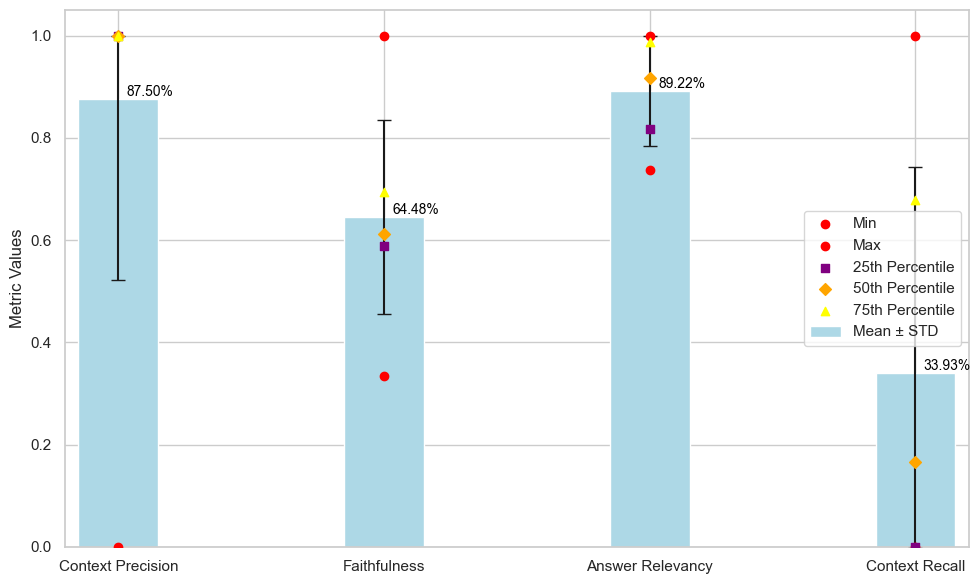

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Given data
data = {
    'count': [8.0, 8.0, 8.0, 8.0],
    'mean': [0.875, 0.644792, 0.892236, 0.339286],
    'std': [0.353553, 0.190379, 0.107493, 0.404412],
    'min': [0.0, 0.333333, 0.736702, 0.0],
    '25%': [1.0, 0.588889, 0.816519, 0.0],
    '50%': [1.0, 0.612500, 0.916506, 0.166667],
    '75%': [1.0, 0.694444, 0.986730, 0.678571],
    'max': [1.0, 1.0, 1.0, 1.0]
}

# Converting dictionary to DataFrame and setting appropriate index
df = pd.DataFrame(data, index=["Context Precision", "Faithfulness", "Answer Relevancy", "Context Recall"])

# Adjusting the position of the mean value annotations to be on top and slightly to the right of the bars

# Setting up the plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Define positions for the bar elements
bar_positions = np.arange(4)

# Define error limits, ensuring they do not exceed 0 and 1
df['std_upper'] = np.minimum(df['mean'] + df['std'], 1)
df['std_lower'] = np.maximum(df['mean'] - df['std'], 0)

# Calculate errors from mean values to upper and lower bounds
errors = [df['mean'] - df['std_lower'], df['std_upper'] - df['mean']]

# Define colors for points exceeding bounds
exceeded_color = 'red'

# Plot bars for mean values and overlay with error bars for std (whiskers)
bars = plt.bar(bar_positions, df['mean'], color='lightblue', width=0.3,
               yerr=errors, capsize=5, label='Mean ± STD')

# Scatter for Min and Max values within bounds
plt.scatter(bar_positions, df['min'], color=exceeded_color, label='Min', zorder=5)
plt.scatter(bar_positions, df['max'], color=exceeded_color, label='Max', zorder=5)

# Scatter for 25%, 50%, and 75% percentiles
plt.scatter(bar_positions, df['25%'], color='purple', label='25th Percentile', zorder=5, marker='s')
plt.scatter(bar_positions, df['50%'], color='orange', label='50th Percentile', zorder=5, marker='D')
plt.scatter(bar_positions, df['75%'], color='yellow', label='75th Percentile', zorder=5, marker='^')

# Annotating the mean values on the bars, slightly to the right
for bar, value in zip(bars, df['mean']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + 0.12, yval, f'{value:.2%}', ha='center', va='bottom', fontsize=10, color='black')

# Adding labels, legend, and title
plt.xticks(bar_positions, df.index)
plt.ylabel('Metric Values', fontsize=12)
plt.legend()

# Reduce space between bars by adjusting x limits
bar_width = 0.2
plt.xlim(bar_positions[0] - bar_width, bar_positions[-1] + bar_width)

# Display the professional plot
plt.tight_layout()
plt.show()



In [57]:
df = result.to_pandas()
df[["context_precision", "faithfulness","answer_relevancy","context_recall"]]

,context_precision,faithfulness,answer_relevancy,context_recall
0,0.0,0.400000,0.924391,1.0
1,0.0,0.500000,0.881020,1.0
2,0.0,0.000000,0.902759,1.0
3,0.0,0.375000,0.974474,1.0
4,0.0,0.666667,0.739574,1.0
5,0.0,0.333333,0.951461,1.0
6,0.0,0.545455,0.999999,1.0
7,0.0,0.272727,0.974018,0.0


In [58]:
df

,question,answer,contexts,ground_truths,context_precision,faithfulness,answer_relevancy,context_recall
0,"What is the process for filing for divorce, an...",In a legal case involving the dissolution of a...,[This legal text provides a summary of the pro...,[Answer:Subquestion in Question: What is the p...,0.0,0.400000,0.924391,1.0
1,"My spouse and I are considering a divorce, but...","In a similar case, the court used Civil Articl...",[This legal text describes the progress of a c...,[Answer:\nSubquestion in Question: My spouse a...,0.0,0.500000,0.881020,1.0
2,I am currently unemployed and going to divorci...,"In the case described, the most important civi...",[This legal text describes the progress of a c...,[Answer:\nSubquestion in Question: I am curren...,0.0,0.000000,0.902759,1.0
3,"As a stay-at-home parent during our marriage,N...","In the case described, the most important civi...",[This legal text describes the progress of a c...,"[Answer:\nSubquestion in Question: ""As a stay-...",0.0,0.375000,0.974474,1.0
4,"John, a wealthy individual, recently passed aw...","In the case of John's contested will, the most...",[This legal text summarizes the progress of a ...,[Answer:\nSubquestion in Question: What are th...,0.0,0.666667,0.739574,1.0
5,What happens if someone dies without a will an...,"In the legal case mentioned, the court dissolv...","[In this legal case, a hereditary communion be...",[Subquestion in Question: What happens if some...,0.0,0.333333,0.951461,1.0
6,Can a will that includes a disinheritance clau...,In a recent legal case involving the successio...,[This legal text summarizes the progress of a ...,[Subquestion in Question: Can a will that incl...,0.0,0.545455,0.999999,1.0
7,If the deceased left a trust for his grandchil...,"In the legal cases mentioned, the court used s...","[In this legal case, a hereditary communion be...",[I am building a question-answer application w...,0.0,0.272727,0.974018,0.0


In [420]:
df.index("mean")

TypeError: 'RangeIndex' object is not callable

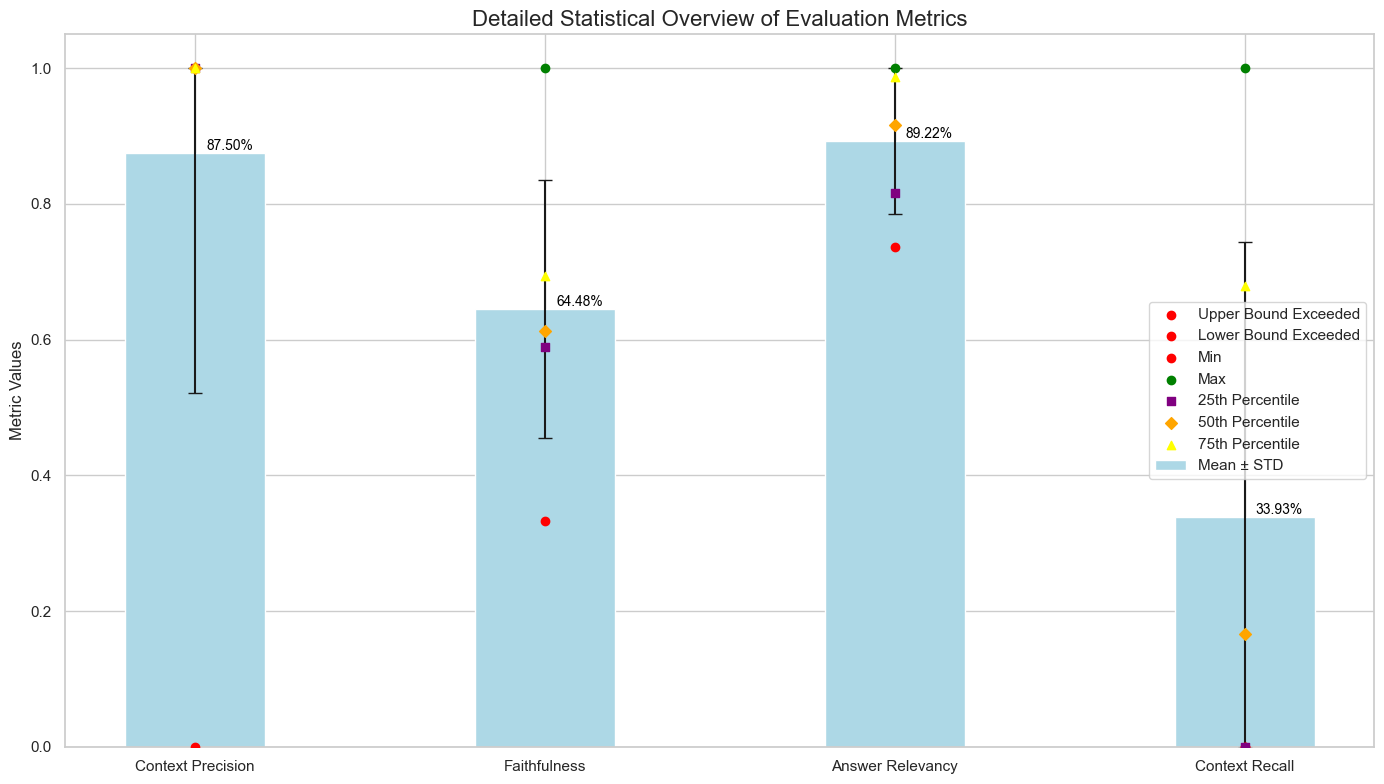

In [ ]:
# Adjusting the position of the mean value annotations to be on top and slightly to the right of the bars

# Setting up the plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Define positions for the bar elements
bar_positions = np.arange(len(df))

# Plot bars for mean values and overlay with error bars for clipped std
bars = plt.bar(bar_positions, df['mean'], color='lightblue', width=0.2,
               yerr=[df['mean'] - df['std_lower_clipped'], df['std_upper_clipped'] - df['mean']],
               capsize=5, label='Mean ± STD')

# Highlight exceeded bounds with red
plt.scatter(bar_positions[upper_exceeded], df['std_upper_clipped'][upper_exceeded], color='red', label='Upper Bound Exceeded', zorder=5)
plt.scatter(bar_positions[lower_exceeded], df['std_lower_clipped'][lower_exceeded], color='red', label='Lower Bound Exceeded', zorder=5)

# Scatter for Min and Max values within bounds
plt.scatter(bar_positions, df['min'], color='red', label='Min', zorder=5)
plt.scatter(bar_positions, df['max'], color='green', label='Max', zorder=5)

# Scatter for 25%, 50%, and 75% percentiles
plt.scatter(bar_positions, df['25%'], color='purple', label='25th Percentile', zorder=5, marker='s')
plt.scatter(bar_positions, df['50%'], color='orange', label='50th Percentile', zorder=5, marker='D')
plt.scatter(bar_positions, df['75%'], color='yellow', label='75th Percentile', zorder=5, marker='^')

# Annotating the mean values on the bars, slightly to the right
for bar, value in zip(bars, df['mean']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + 0.10, yval, f'{value:.2%}', ha='center', va='bottom', fontsize=10, color='black')

# Adding labels, legend, and title
plt.xticks(bar_positions, df.index)
plt.ylabel('Metric Values', fontsize=12)
plt.title('Detailed Statistical Overview of Evaluation Metrics', fontsize=16)
plt.legend()

# Display the professional plot
plt.tight_layout()
plt.show()


## Visual checking

In [471]:
dataset = pd.DataFrame.from_dict(data)

In [484]:
dataset

,question,answer,contexts,ground_truth
0,"What is the process for filing for divorce, an...",In a legal case involving the dissolution of a...,This legal text provides a summary of the prog...,Answer:Subquestion in Question: What is the pr...
1,"My spouse and I are considering a divorce, but...","In a similar case that lasted for 7 years, the...",This legal text describes the progress of a ca...,Answer:\nSubquestion in Question: My spouse an...
2,I am currently unemployed and going to divorci...,"In a similar case that lasted for 7 years, the...",This legal text describes the progress of a ca...,Answer:\nSubquestion in Question: I am current...
3,"As a stay-at-home parent during our marriage,N...","In the case described, the most important civi...",This legal text describes the progress of a ca...,"Answer:\nSubquestion in Question: ""As a stay-a..."
4,"John, a wealthy individual, recently passed aw...","In the case of John's contested will, the most...",This legal text summarizes the progress of a c...,Answer:\nSubquestion in Question: What are the...
5,What happens if someone dies without a will an...,"In the legal case mentioned, the court dissolv...","In this legal case, a hereditary communion bet...",Subquestion in Question: What happens if someo...
6,Can a will that includes a disinheritance clau...,In a recent legal case involving the successio...,This legal text summarizes the progress of a c...,Subquestion in Question: Can a will that inclu...
7,If the deceased left a trust for his grandchil...,"In the legal cases mentioned, the most importa...","In this legal case, a hereditary communion bet...",I am building a question-answer application wi...


In [491]:
dataset

,question,answer,contexts,ground_truth
0,"What is the process for filing for divorce, an...",In a legal case involving the dissolution of a...,This legal text provides a summary of the prog...,Answer:Subquestion in Question: What is the pr...
1,"My spouse and I are considering a divorce, but...","In a similar case that lasted for 7 years, the...",This legal text describes the progress of a ca...,Answer:\nSubquestion in Question: My spouse an...
2,I am currently unemployed and going to divorci...,"In a similar case that lasted for 7 years, the...",This legal text describes the progress of a ca...,Answer:\nSubquestion in Question: I am current...
3,"As a stay-at-home parent during our marriage,N...","In the case described, the most important civi...",This legal text describes the progress of a ca...,"Answer:\nSubquestion in Question: ""As a stay-a..."
4,"John, a wealthy individual, recently passed aw...","In the case of John's contested will, the most...",This legal text summarizes the progress of a c...,Answer:\nSubquestion in Question: What are the...
5,What happens if someone dies without a will an...,"In the legal case mentioned, the court dissolv...","In this legal case, a hereditary communion bet...",Subquestion in Question: What happens if someo...
6,Can a will that includes a disinheritance clau...,In a recent legal case involving the successio...,This legal text summarizes the progress of a c...,Subquestion in Question: Can a will that inclu...
7,If the deceased left a trust for his grandchil...,"In the legal cases mentioned, the most importa...","In this legal case, a hereditary communion bet...",I am building a question-answer application wi...


In [506]:
def get_embeddings(text_list, model="text-embedding-ada-002"):
    """
    Get embeddings for a list of strings using OpenAI's OpenAIEmbeddings class.
    
    Parameters:
        text_list (list of str): The list of text strings to embed.
        model (str): The model ID of the embedding model to use.
    
    Returns:
        list of list of float: The embeddings for the provided text list.
    """
    try:
        # Initialize the OpenAIEmbeddings object with the specified model
        embedder = OpenAIEmbeddings()
        
        # Process the list of texts and get embeddings
        embeddings = embedder.embed_documents(text_list)
        
        return embeddings

    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
embeddings_context  = get_embeddings(context)
embeddings_question  = get_embeddings(questions)
embeddings_gt  = get_embeddings(gt)
embeddings_answer  = get_embeddings(answers)

In [507]:
len(embeddings_question)

8

In [508]:
# Convert lists of embeddings into a DataFrame
df_embeddings = pd.DataFrame({
    'Context': embeddings_context,
    'Question': embeddings_question,
    'Ground Truth': embeddings_gt,
    'Answer': embeddings_answer
})

df_embeddings

,Context,Question,Ground Truth,Answer
0,"[0.00521901071442329, 0.02307565172325455, 0.0...","[0.01455869695329823, 0.012649360090707521, 0....","[0.023952594418887193, 0.020062856704482847, 0...","[0.024225609197058375, 0.028692081014060816, 0..."
1,"[0.0020240109219731577, 0.020826186838960717, ...","[-0.005716942480345752, -0.009651732087360445,...","[0.001815075523141617, -0.012710412051918621, ...","[0.0034011327501830943, 0.00737586897328999, 0..."
2,"[0.0020240109219731577, 0.020826186838960717, ...","[-0.003985893220381478, -0.010250377817423849,...","[0.01970839855001603, 0.005915708413772621, 0....","[0.01928231574042047, 0.01800304553356245, 0.0..."
3,"[0.0020240109219731577, 0.020826186838960717, ...","[-0.010501181524144292, 0.0009765117543323327,...","[0.01913279476399781, 0.008230785818471064, 0....","[0.018481338165543038, 0.027895352436844125, 0..."
4,"[-0.0003191825585684032, 0.002483788923935949,...","[-0.006943320510424314, 0.0040352633923757125,...","[-0.001867943052841445, 0.014849135318222266, ...","[-0.0015821802115420845, 0.015899476976594138,..."
5,"[-0.0038671915881122528, 0.008051762512225303,...","[0.013596832450532233, -0.01443115403519873, 0...","[0.011638461378647122, -0.006951656984383403, ...","[0.0159985546572611, 0.021552107298604094, 0.0..."
6,"[-0.0003191825585684032, 0.002483788923935949,...","[-0.013314051073726395, -0.002837977269820196,...","[-0.008628218075284052, 0.0008724603681717558,...","[0.010957251063202722, 0.016497434687333116, 0..."
7,"[-0.0038671915881122528, 0.008051762512225303,...","[-0.003657616148912014, -0.006017368653262113,...","[0.009420905370554261, 0.023371091381217422, 0...","[0.01087726880230036, 0.024281646116614593, 0...."


In [516]:
df_embeddings.shape

(8, 4)

C:\Users\ALBER\AppData\Local\Temp\ipykernel_24728\3155121342.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  embeddings_array = np.vstack(df_embeddings.applymap(lambda emb: np.array(emb)).values.ravel())


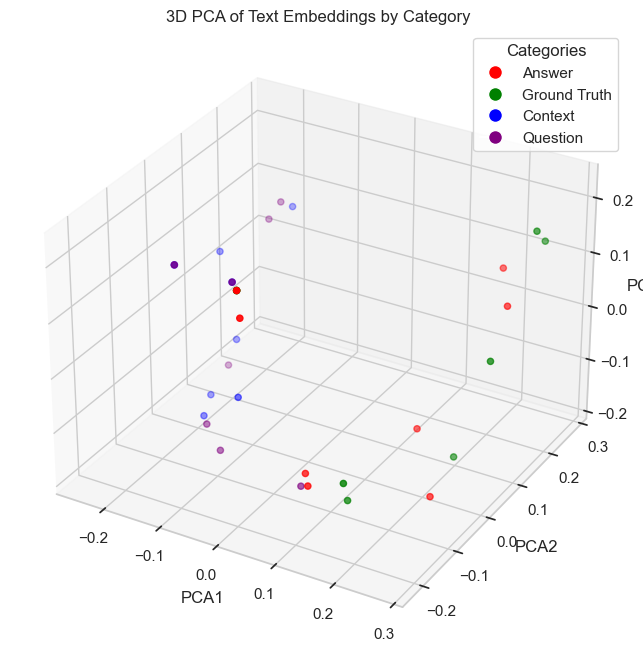

In [518]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_embeddings is a DataFrame where each cell contains a single embedding vector,
# and each column represents a category such as 'Context', 'Question', 'Ground Truth', 'Answer'.

# Flatten the DataFrame embeddings into a 2D array suitable for PCA
# This requires stacking the embeddings from each column into one continuous array
embeddings_array = np.vstack(df_embeddings.applymap(lambda emb: np.array(emb)).values.ravel())

# Perform PCA
pca = PCA(n_components=3)
embeddings_reduced = pca.fit_transform(embeddings_array)

# The number of points in each category
n_context = df_embeddings['Context'].size
n_question = df_embeddings['Question'].size
n_gt = df_embeddings['Ground Truth'].size
n_answer = df_embeddings['Answer'].size

# Create labels and colors for each category
labels = ['Context'] * n_context + ['Question'] * n_question + ['Ground Truth'] * n_gt + ['Answer'] * n_answer
colors = ['red'] * n_context + ['green'] * n_question + ['blue'] * n_gt + ['purple'] * n_answer

# Initialize figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA-reduced embeddings
scatter = ax.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], embeddings_reduced[:, 2], c=colors)

# Create a legend
legend_labels = list(set(labels))
legend_colors = ['red', 'green', 'blue', 'purple']  # Maintain the order as in legend_labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                             markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=legend_handles, title="Categories")

# Label the axes
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Set title
plt.title('3D PCA of Text Embeddings by Category')

# Show plot
plt.show()



array([[ 0.00521901,  0.02307565,  0.01476302, ..., -0.01732698,
        -0.01897331, -0.03470794],
       [ 0.00202401,  0.02082619,  0.00404461, ..., -0.01586498,
         0.00729871, -0.01664187],
       [ 0.00202401,  0.02082619,  0.00404461, ..., -0.01586498,
         0.00729871, -0.01664187],
       ...,
       [ 0.01599855,  0.02155211,  0.01809296, ..., -0.00408747,
         0.00701288, -0.02856499],
       [ 0.01095725,  0.01649743,  0.02875424, ..., -0.00692865,
         0.010157  , -0.02228385],
       [ 0.01087727,  0.02428165,  0.02544492, ..., -0.00567597,
         0.00475672, -0.0219551 ]])

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)

# Flatten all embeddings and then apply PCA
all_embeddings = np.vstack([np.array(v) for v in embedded.values()])
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split the reduced data back into the original categories
splits = np.cumsum([len(v) for v in embedded_data.values()])
reduced_data = np.split(reduced_embeddings, indices_or_sections=splits[:-1])

In [485]:
# Get embeddings for each feature
embedded_data = {key: get_embeddings(value) for key, value in dataset.items()}

KeyboardInterrupt: 